In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cdsapi
import os
import time
import zipfile
import xarray as xr
from glob import glob
from sklearn.mixture import GaussianMixture

!echo "url: https://cds.climate.copernicus.eu/api" >> ~/.cdsapirc
!echo "key: 8ed01691-cb79-45f4-b426-815241203696" >> ~/.cdsapirc

# Funciones


## Funciones auxiliares

In [145]:
def pick_vars(ds):
    """Devuelve todas las variables 'típicas de superficie' que existan en el Dataset."""
    cand = ["t2m_C", "t2m", "tp", "swvl1", "cp", "lsp"]
    found = [k for k in cand if k in ds.data_vars]
    return found

def _pick_dim(ds, candidates):
    for c in candidates:
        if c in ds.dims or c in ds.coords:
            return c
    return None

def _ensure_celsius(da):
    """Convierte Kelvin→°C si aplica, manteniendo attrs."""
    units = da.attrs.get("units", "")
    if units.lower() in ["k", "kelvin"]:
        out = da - 273.15
        out.attrs.update(da.attrs)
        out.attrs["units"] = "°C"
        return out
    return da

def _pick_point_coords(ds, prefer_lat=-33.45, prefer_lon=-70.65):
    """Busca el punto más cercano a coords favoritas; si falla, usa medianas."""
    lat_name = "latitude" if "latitude" in ds.coords else "lat"
    lon_name = "longitude" if "longitude" in ds.coords else "lon"
    try:
        latv = float(ds[lat_name].sel({lat_name: prefer_lat}, method="nearest"))
        lonv = float(ds[lon_name].sel({lon_name: prefer_lon}, method="nearest"))
        return lat_name, lon_name, latv, lonv
    except Exception:
        latv = float(ds[lat_name].median())
        lonv = float(ds[lon_name].median())
        return lat_name, lon_name, latv, lonv

def _assert_dims(da, req=("time","latitude","longitude")):
    missing = [d for d in req if d not in da.dims]
    if missing:
        raise ValueError(f"La variable {da.name} no tiene dims {req}. Dims actuales: {da.dims}")

def _shape_info(tag, x):
    if hasattr(x, "sizes"):
        print(f"[{tag}] dims: {dict(x.sizes)}")
    else:
        try:
            print(f"[{tag}] shape: {tuple(x.shape)}")
        except Exception:
            print(f"[{tag}] tipo: {type(x)}")

## Funciones de descarga y concatenado

In [146]:
def _build_params(area, year):
    """Parametros para el request ERA5 (ajusta aquí variables/tiempos/meses si cambian)."""
    return {
        "product_type": "reanalysis",
        "variable": [
            "2m_temperature",                      # t2m
            "volumetric_soil_water_layer_1",       # swvl1
        ],
        "year": [str(year)],
        "month": [f"{m:02d}" for m in range(1, 13)],
        "day": [f"{d:02d}" for d in range(1, 32)],          # días "largos" aceptados por CDS
        "time": [f"{h:02d}:00" for h in range(0,24)],         # 24 horas, importante para precip
        "area": area,                                       # [N, W, S, E]
        "format": "netcdf",
    }

def _build_params_pp(area, year):
    """Parametros para el request ERA5 (ajusta aquí variables/tiempos/meses si cambian)."""
    return {
        "product_type": "reanalysis",
        "variable": [
            "convective_precipitation",            # cp
            "large_scale_precipitation",           # lsp
        ],
        "year": [str(year)],
        "month": [f"{m:02d}" for m in range(1, 13)],
        "day": [f"{d:02d}" for d in range(1, 32)],          # días "largos" aceptados por CDS
        "time": [f"{h:02d}:00" for h in range(0,24)],         # 24 horas, importante para precip
        "area": area,                                       # [N, W, S, E]
        "format": "netcdf",
    }


def _validate_file_min_size(path, expected_min_size_bytes):
    """True si el archivo existe y supera un umbral mínimo de tamaño."""
    return os.path.exists(path) and os.path.getsize(path) > expected_min_size_bytes

def _extract_if_zip(tmp_nc, year, output_dir):
    """
    Si tmp_nc es ZIP, extrae a una carpeta por año y retorna lista de .nc extraídos.
    Si no es ZIP, retorna None.
    """
    if not zipfile.is_zipfile(tmp_nc):
        return None

    year_dir = os.path.join(output_dir, f"era5_{year}")
    os.makedirs(year_dir, exist_ok=True)
    with zipfile.ZipFile(tmp_nc, "r") as z:
        z.extractall(year_dir)
    nc_found = sorted(glob(os.path.join(year_dir, "*.nc")))
    if not nc_found:
        raise RuntimeError("ZIP sin .nc dentro.")
    try:
        os.remove(tmp_nc)
    except Exception:
        pass
    return nc_found

def _finalize_nc_direct(tmp_nc, year, output_dir):
    """No renombra: deja el archivo tal cual CDS lo descargó."""
    # Simplemente devolver la ruta descargada // FUNCIÓN DUMMY QUE PODRÍA SERVIR EN EL FUTURO PARA RENOMBRAR LOS ARCHIVOS DESCARGADOS
    return tmp_nc


def _download_one_year(cds_client, params, tmp_nc, expected_min_size_bytes):
    """
    Descarga un año (una vez). Lanza excepción si falla o si el tamaño es sospechoso.
    Retorna la ruta del tmp_nc al terminar la descarga.
    """
    cds_client.retrieve("reanalysis-era5-single-levels", params, tmp_nc)
    if not _validate_file_min_size(tmp_nc, expected_min_size_bytes):
        raise ValueError("Descarga sospechosamente pequeña o incompleta.")
    return tmp_nc

def _download_one_year_with_retries(
    area,
    year,
    output_dir,
    reintentos,
    expected_min_size_bytes,
    backoff_fn=None,
    tipo="temp",   # "temp" o "pp"
):
    """
    Reintenta descargas del año. Retorna lista de rutas .nc (1 si NC directo, n si ZIP).
    Lanza excepción si se agotan reintentos (el caller decide qué hacer con el fallo).

    tipo:
        "temp" -> usa _build_params(area, year)
        "pp"   -> usa _build_params_pp(area, year)
    """
    if backoff_fn is None:
        backoff_fn = lambda intento: min(60, 5 * intento)  # backoff suave

    c = cdsapi.Client()

    if tipo == "temp":
        params = _build_params(area, year)
    elif tipo == "pp":
        params = _build_params_pp(area, year)
    else:
        raise ValueError(f"tipo desconocido: {tipo!r}. Usa 'temp' o 'pp'.")

    tmp_nc = os.path.join(output_dir, f"_tmp_era5_{tipo}_{year}.nc")

    for intento in range(1, reintentos + 1):
        if os.path.exists(tmp_nc):
            try:
                os.remove(tmp_nc)
            except Exception:
                pass

        try:
            _download_one_year(c, params, tmp_nc, expected_min_size_bytes)
            extracted = _extract_if_zip(tmp_nc, year, output_dir)
            if extracted is not None:
                return extracted  # lista de .nc
            return [_finalize_nc_direct(tmp_nc, year, output_dir)]
        except Exception as e:
            print(f"Intento {intento}/{reintentos} para {year} (tipo={tipo}) falló: {e}")
            if intento < reintentos:
                time.sleep(backoff_fn(intento))
            else:
                if os.path.exists(tmp_nc):
                    try:
                        os.remove(tmp_nc)
                    except Exception:
                        pass
                raise



# Esta función sigue provocando crash en colabs
# así que he implementado una modificación más abajo
def _concat_netcdfs(nc_paths, merged_path, chunk_time):
    """Concatena múltiples NetCDFs por coordenadas y guarda a merged_path."""
    ds = xr.open_mfdataset(
        nc_paths,
        combine="nested", # corrección: "by_coords" -> "nested", al ser la misma grilla
          # no reindexea y se utiliza menos recursos
        parallel=True,
        chunks={"valid_time": chunk_time},
        engine="netcdf4",
    ).sortby("valid_time")
    ds.to_netcdf(merged_path)
    ds.close()
    return merged_path

def concatenar_rango(path_in, path_out, name_out="concatenado", chunk_time=240):
    """
    Concatena TODOS los .nc en path_in a lo largo de la dimensión temporal real
    ('valid_time' si existe, si no 'time'), aplica chunking y escribe name_out.nc.
    """
    import os
    import glob
    import xarray as xr

    os.makedirs(path_in, exist_ok=True)
    os.makedirs(path_out, exist_ok=True)

    nc_files = sorted(glob.glob(os.path.join(path_in, "*.nc")))
    if not nc_files:
        raise FileNotFoundError(f"No se encontraron .nc en: {path_in}")

    print(f"\nEncontrados {len(nc_files)} archivos:")
    for f in nc_files:
        print("  -", os.path.basename(f))

    print("\nAbriendo archivos...")
    ds_list = []
    for f in nc_files:
        ds = xr.open_dataset(f, engine="netcdf4")  # sin chunks aquí
        print(f"  ✔ {os.path.basename(f)} abierto")
        ds_list.append(ds)

    # Detectar dimensión temporal real en el primer dataset
    first = ds_list[0]
    if "valid_time" in first.dims:
        time_dim = "valid_time"
    elif "time" in first.dims:
        time_dim = "time"
    else:
        raise KeyError("No se encontró ni 'valid_time' ni 'time' en los archivos.")

    print(f"\nConcatenando a lo largo de '{time_dim}'...")
    ds_concat = xr.concat(
        ds_list,
        dim=time_dim,
        combine_attrs="drop_conflicts",
        join="outer",
    )

    # Ordenar por la dimensión temporal real
    ds_concat = ds_concat.sortby(time_dim)

    print(f"Aplicando chunking: {time_dim}={chunk_time}")
    ds_concat = ds_concat.chunk({time_dim: chunk_time})

    output_path = os.path.join(path_out, f"{name_out}.nc")
    print(f"Escribiendo archivo final en:\n  {output_path}\n")
    ds_concat.to_netcdf(output_path)

    print("✔ Proceso completado.")
    return output_path



def _classify_nc_path(path):
    """
    Clasifica el archivo .nc según su nombre.
    Devuelve 'accum', 'instant' u 'other'.
    """
    name = os.path.basename(path)
    if "data_stream-oper_stepType-accum" in name:
        return "accum"
    if "data_stream-oper_stepType-instant" in name:
        return "instant"
    return "other"

# ---------- Función principal (orquestadora) ----------


def descargar_era5_rango(
    area,
    year_start,
    year_end,
    output_dir="data_era",
    expected_min_size_bytes=100_000,
    chunk_time=240,   # se mantiene aunque aquí no se usa
    reintentos=3,
    tipo="temp",      # "temp" -> _build_params, "pp" -> _build_params_pp
):
    """
    SOLO descarga y clasifica los .nc, NO concatena.

    Retorna:
        {
            "accum":   [lista de .nc acumulados],
            "instant": [lista de .nc instantáneos],
            "other":   [lista de .nc no clasificados],
            "years_ok":   [...],
            "years_fail": [...],
        }

    Parámetro
    ---------
    tipo : str
        "temp" -> usa _build_params(area, year)
        "pp"   -> usa _build_params_pp(area, year)
    """
    os.makedirs(output_dir, exist_ok=True)

    nc_paths_accum = []
    nc_paths_instant = []
    nc_paths_other = []

    years_ok, years_fail = [], []

    for year in range(year_start, year_end + 1):
        print(f"\n=== Procesando {year} (tipo={tipo}) ===")
        try:
            nc_paths_year = _download_one_year_with_retries(
                area=area,
                year=year,
                output_dir=output_dir,
                reintentos=reintentos,
                expected_min_size_bytes=expected_min_size_bytes,
                tipo=tipo,
            )

            # Clasificación
            for p in nc_paths_year:
                kind = _classify_nc_path(p)
                if kind == "accum":
                    nc_paths_accum.append(p)
                elif kind == "instant":
                    nc_paths_instant.append(p)
                else:
                    nc_paths_other.append(p)

            years_ok.append(year)
            print(f"OK {year}: {len(nc_paths_year)} archivo(s) .nc")

        except Exception as e:
            years_fail.append(year)
            print(f"❌ {year}: se agotaron los reintentos. Motivo: {e}")

    print("\n=== Resumen de años ===")
    print(f"Éxito: {years_ok}" if years_ok else "Éxito: ninguno")
    print(f"Fallidos: {years_fail}" if years_fail else "Fallidos: ninguno")

    return {
        "accum": nc_paths_accum,
        "instant": nc_paths_instant,
        "other": nc_paths_other,
        "years_ok": years_ok,
        "years_fail": years_fail,
    }


## Funciones para gráficar

In [147]:
import numpy as np
from sklearn.mixture import GaussianMixture

def ajustar_mezcla_gaussiana_1d_fijo(data, n_componentes=2, random_state=0):
    """
    Ajusta una mezcla gaussiana 1D con un número fijo de componentes.

    Parámetros
    ----------
    data : array-like
        Muestra 1D (se eliminan NaN).
    n_componentes : int
        Número fijo de gaussianas a ajustar.
    random_state : int
        Semilla para reproducibilidad.

    Devuelve
    --------
    model : GaussianMixture
        Modelo ajustado con n_componentes gaussianas.
    """
    x = np.asarray(data).ravel()
    x = x[~np.isnan(x)]

    if x.size == 0:
        return None

    X = x.reshape(-1, 1)

    model = GaussianMixture(
        n_components=n_componentes,
        covariance_type="full",
        random_state=random_state
    )

    model.fit(X)
    return model



def evaluar_mezclas_gaussianas_1d(data, max_components=5, bins=50, random_state=0):
    """
    Evalúa mezclas gaussianas 1D para K = 1..max_components.

    Parámetros
    ----------
    data : array-like
        Datos 1D (se eliminan NaN).
    max_components : int
        Nº máximo de gaussianas a evaluar.
    bins : int
        Nº de bins para el histograma (solo para el RMSE frente al histograma).
    random_state : int
        Semilla para reproducibilidad.

    Devuelve
    --------
    resultados : list of dict
        Lista de diccionarios, uno por K, con claves:
        - 'K'           : nº de componentes
        - 'loglik'      : log-verosimilitud total
        - 'loglik_med'  : log-verosimilitud media por dato
        - 'AIC'
        - 'BIC'
        - 'rmse_hist'   : RMSE entre densidad empírica (hist) y densidad del modelo
    """
    x = np.asarray(data).ravel()
    x = x[~np.isnan(x)]

    resultados = []
    if x.size == 0:
        return resultados

    X = x.reshape(-1, 1)

    # Histograma empírico (densidad)
    counts, bin_edges = np.histogram(x, bins=bins, density=True)
    x_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])
    Xc = x_centers.reshape(-1, 1)

    for K in range(1, max_components + 1):
        gm = GaussianMixture(
            n_components=K,
            covariance_type="full",
            random_state=random_state
        )
        gm.fit(X)

        # log-verosimilitud total y media
        loglik_med = gm.score(X)           # loglik/n
        loglik_tot = loglik_med * x.size

        # AIC y BIC incorporan penalización por complejidad
        aic = gm.aic(X)
        bic = gm.bic(X)

        # Densidad del modelo en los centros del histograma
        log_pdf_model = gm.score_samples(Xc)
        pdf_model = np.exp(log_pdf_model)

        # RMSE entre densidad empírica y modelo
        rmse = np.sqrt(np.mean((counts - pdf_model) ** 2))

        resultados.append({
            "K": K,
            "loglik": loglik_tot,
            "loglik_med": loglik_med,
            "AIC": aic,
            "BIC": bic,
            "rmse_hist": rmse,
        })

    return resultados

In [148]:
def plot_mapas_promedio_por_anio(da, var, ds, punto_interes):
    """
    Genera una figura de 2 filas x n columnas (n = número de años):
    - Fila 1: mapa del promedio anual de la variable en todo el dominio.
    - Fila 2: mapa del promedio anual, marcando el punto de interés.
    """
    import matplotlib.pyplot as plt
    import numpy as np

    # Coordenadas
    lat_name = "latitude" if "latitude" in ds.coords else "lat"
    lon_name = "longitude" if "longitude" in ds.coords else "lon"

    # Años presentes en el dataset
    years = np.unique(da["time"].dt.year.values)
    n_years = len(years)

    # Punto de interés
    lat_p, lon_p = punto_interes

    # Figura
    fig, axes = plt.subplots(
        2, n_years,
        figsize=(4 * n_years, 8),
        squeeze=False
    )

    for j, year in enumerate(years):
        # Subconjunto del año y promedio en tiempo
        da_year_mean = da.sel(time=str(year)).mean(dim="time")

        # --- Fila 1: mapa promedio anual ---
        ax_top = axes[0, j]
        da_year_mean.plot.imshow(ax=ax_top, robust=True)
        ax_top.set_title(f"{var} promedio — Año {year}")
        ax_top.set_xlabel(lon_name)
        ax_top.set_ylabel(lat_name)

        # --- Fila 2: mismo mapa + punto de interés ---
        ax_bottom = axes[1, j]
        da_year_mean.plot.imshow(ax=ax_bottom, robust=True)
        ax_bottom.scatter(lon_p, lat_p, marker="x", s=40)  # marca el monte
        ax_bottom.set_title(
            f"{var} promedio — Año {year}\nPunto ({lat_p:.2f}, {lon_p:.2f})"
        )
        ax_bottom.set_xlabel(lon_name)
        ax_bottom.set_ylabel(lat_name)

    plt.tight_layout()
    plt.show()



In [149]:
def plot_histogramas_por_anio(da, var, ds, punto_interes, n=1, nbins = 100):
    """
    Genera una figura de 2 filas x (n_years+1) columnas:
    - Columna 0:
        Fila 1: histograma del campo completo (todos los años)
        Fila 2: histograma del punto de interés (todos los años) + mixture(n)
    - Columnas 1..n_years:
        Fila 1: histograma del campo completo por año
        Fila 2: histograma del punto de interés por año + mixture(n)

    Devuelve:
    - medias_mix: medias del mixture TOTAL (todos los años)
    - desvs_mix : desviaciones del mixture TOTAL (todos los años)
    """

    # Coordenadas
    lat_name = "latitude" if "latitude" in ds.coords else "lat"
    lon_name = "longitude" if "longitude" in ds.coords else "lon"

    lat_min = float(ds[lat_name].min())
    lat_max = float(ds[lat_name].max())
    lon_min = float(ds[lon_name].min())
    lon_max = float(ds[lon_name].max())

    # Años
    years = np.unique(da["time"].dt.year.values)
    years_sorted = np.sort(years)          # para las columnas del plot (ascendente)
    n_years = len(years_sorted)

    # Punto de interés
    lat_p, lon_p = punto_interes
    punto_da = da.sel({lat_name: lat_p, lon_name: lon_p}, method="nearest")

    # Figura: +1 columna para "todos los años"
    n_cols = n_years + 1
    fig, axes = plt.subplots(2, n_cols, figsize=(4 * n_cols, 8), squeeze=False)

    titulo_global = (
        f"Histograma de {var} — "
        f"Lat [{lat_min:.2f}, {lat_max:.2f}] • "
        f"Lon [{lon_min:.2f}, {lon_max:.2f}]"
    )

    # ------------------------------------------------------------------
    # Columna 0: TODOS LOS AÑOS
    # ------------------------------------------------------------------
    # Campo completo (todos los tiempos)
    ax_top_all = axes[0, 0]
    da.plot.hist(ax=ax_top_all, bins=nbins)
    ax_top_all.set_title(f"{titulo_global}\nTodos los años")
    ax_top_all.set_xlabel(f"{var} ({da.attrs.get('units','')})")
    ax_top_all.set_ylabel("Frecuencia")

    # Punto de interés (todos los años)
    ax_bottom_all = axes[1, 0]
    datos_all = np.asarray(punto_da.values).ravel()
    datos_all = datos_all[~np.isnan(datos_all)]

    model_all = None  # <-- IMPORTANTE: para devolverlo después

    if datos_all.size > 0:
        counts_all, bin_edges_all, _ = ax_bottom_all.hist(datos_all, bins=nbins, alpha=0.7)
        ax_bottom_all.set_title(f"Punto ({lat_p:.2f}, {lon_p:.2f}) — Todos los años")
        ax_bottom_all.set_xlabel(f"{var} ({da.attrs.get('units','')})")
        ax_bottom_all.set_ylabel("Frecuencia")

        # Ajuste mixture(n) para todos los años
        model_all = ajustar_mezcla_gaussiana_1d_fijo(datos_all, n_componentes=n)
        if model_all is not None:
            x_min_all, x_max_all = datos_all.min(), datos_all.max()
            xs_all = np.linspace(x_min_all, x_max_all, 300)
            Xs_all = xs_all.reshape(-1, 1)

            bin_width_all = bin_edges_all[1] - bin_edges_all[0]
            scale_all = datos_all.size * bin_width_all

            log_pdf_all = model_all.score_samples(Xs_all)
            pdf_total_all = np.exp(log_pdf_all) * scale_all
            ax_bottom_all.plot(xs_all, pdf_total_all, label=f"Mixture K={n}")

            weights_all = model_all.weights_
            means_all = model_all.means_.ravel()
            stds_all  = np.sqrt(model_all.covariances_.reshape(-1))

            for k in range(n):
                mu = means_all[k]
                sigma = stds_all[k]
                w = weights_all[k]
                comp_pdf_all = (
                    w
                    * (1.0 / (np.sqrt(2 * np.pi) * sigma))
                    * np.exp(-0.5 * ((xs_all - mu) / sigma) ** 2)
                ) * scale_all
                ax_bottom_all.plot(
                    xs_all, comp_pdf_all, linestyle="--", alpha=0.9,
                    label=f"Comp {k+1}: μ={mu:.2f}, σ={sigma:.2f}"
                )

            ax_bottom_all.legend(fontsize=8)

    else:
        ax_bottom_all.set_title(f"Punto ({lat_p:.2f}, {lon_p:.2f}) — Todos los años (sin datos)")

    # ------------------------------------------------------------------
    # Columnas 1..n_years: año a año (solo visualización)
    # ------------------------------------------------------------------
    for idx, year in enumerate(years_sorted):
        col = idx + 1

        # Campo completo en el año
        da_year = da.sel(time=str(year))
        ax_top = axes[0, col]

        da_year.plot.hist(ax=ax_top, bins=nbins)
        ax_top.set_title(f"Año {year}")
        ax_top.set_xlabel(f"{var} ({da.attrs.get('units','')})")
        ax_top.set_ylabel("Frecuencia")

        # Punto de interés en el año
        punto_year = punto_da.sel(time=str(year))
        ax_bottom = axes[1, col]

        datos = np.asarray(punto_year.values).ravel()
        datos = datos[~np.isnan(datos)]

        if datos.size == 0:
            ax_bottom.set_title(
                f"Punto ({lat_p:.2f}, {lon_p:.2f}) — Año {year} (sin datos)"
            )
            ax_bottom.set_xlabel(f"{var} ({da.attrs.get('units','')})")
            ax_bottom.set_ylabel("Frecuencia")
            continue

        counts, bin_edges, _ = ax_bottom.hist(datos, bins=nbins, alpha=0.7)
        ax_bottom.set_title(f"Punto ({lat_p:.2f}, {lon_p:.2f}) — Año {year}")
        ax_bottom.set_xlabel(f"{var} ({da.attrs.get('units','')})")
        ax_bottom.set_ylabel("Frecuencia")

        # Mixture(n) en ese año (solo plot)
        model = ajustar_mezcla_gaussiana_1d_fijo(datos, n_componentes=n)
        if model is None:
            continue

        x_min, x_max = datos.min(), datos.max()
        xs = np.linspace(x_min, x_max, 300)
        Xs = xs.reshape(-1, 1)

        bin_width = bin_edges[1] - bin_edges[0]
        scale = datos.size * bin_width

        log_pdf = model.score_samples(Xs)
        pdf_total = np.exp(log_pdf) * scale
        ax_bottom.plot(xs, pdf_total, label=f"Mixture K={n}")

        weights = model.weights_
        means = model.means_.ravel()
        stds = np.sqrt(model.covariances_.reshape(-1))

        for k in range(n):
            mu = means[k]
            sigma = stds[k]
            w = weights[k]
            comp_pdf = (
                w
                * (1.0 / (np.sqrt(2 * np.pi) * sigma))
                * np.exp(-0.5 * ((xs - mu) / sigma) ** 2)
            ) * scale
            ax_bottom.plot(
                xs, comp_pdf, linestyle="--", alpha=0.9,
                label=f"Comp {k+1}: μ={mu:.2f}, σ={sigma:.2f}"
            )

        ax_bottom.legend(fontsize=8)

    plt.tight_layout()
    plt.show()

    # ------------------------------------------------------------------
    # DEVOLVER SOLO LAS MEDIAS Y DEVS DEL MIXTURE TOTAL
    # ------------------------------------------------------------------
    if model_all is not None:
        medias_mix = model_all.means_.ravel()
        desvs_mix  = np.sqrt(model_all.covariances_.reshape(-1))
    else:
        medias_mix = np.array([np.nan])
        desvs_mix  = np.array([np.nan])

    return medias_mix, desvs_mix



In [150]:
def plot_histogramas_lluvia_por_anio(
    da,
    var,
    ds,
    punto_interes,
    nbins=100,
    log_y=True,
    solo_positivos=False,
):
    """
    Genera una figura de 2 filas x (n_years+1) columnas:

    - Columna 0 (TODOS LOS AÑOS):
        Fila 1: histograma del CAMPO COMPLETO (todas las grillas, todos los tiempos)
        Fila 2: histograma del PUNTO DE INTERÉS (todos los tiempos)

    - Columnas 1..n_years (por año):
        Fila 1: histograma del CAMPO COMPLETO restringido a ese año
        Fila 2: histograma del PUNTO DE INTERÉS restringido a ese año

    Opciones:
    - log_y: usa escala logarítmica en el eje Y.
    - solo_positivos: filtra datos <= 0 (útil para lluvia).
    """

    # -------------------------
    # Coordenadas
    # -------------------------
    lat_name = "latitude" if "latitude" in ds.coords else "lat"
    lon_name = "longitude" if "longitude" in ds.coords else "lon"

    lat_min = float(ds[lat_name].min())
    lat_max = float(ds[lat_name].max())
    lon_min = float(ds[lon_name].min())
    lon_max = float(ds[lon_name].max())

    # -------------------------
    # Años
    # -------------------------
    years = np.unique(da["time"].dt.year.values)
    years_sorted = np.sort(years)
    n_years = len(years_sorted)

    # -------------------------
    # Punto de interés
    # -------------------------
    lat_p, lon_p = punto_interes
    punto_da = da.sel({lat_name: lat_p, lon_name: lon_p}, method="nearest")

    # -------------------------
    # Rango global en X
    # -------------------------
    datos_campo_all = np.asarray(da.values).ravel()
    datos_campo_all = datos_campo_all[np.isfinite(datos_campo_all)]

    if solo_positivos:
        datos_campo_all = datos_campo_all[datos_campo_all > 0]

    if datos_campo_all.size > 0:
        x_min_global = float(datos_campo_all.min())
        x_max_global = float(datos_campo_all.max())
    else:
        x_min_global, x_max_global = 0.0, 1.0  # fallback

    # -------------------------
    # Figura
    # -------------------------
    n_cols = n_years + 1
    fig, axes = plt.subplots(2, n_cols, figsize=(4 * n_cols, 8), squeeze=False)

    titulo_global = (
        f"Histogramas de {var} — "
        f"Lat [{lat_min:.2f}, {lat_max:.2f}] • "
        f"Lon [{lon_min:.2f}, {lon_max:.2f}]"
    )

    # ==========================================================
    # Columna 0: TODOS LOS AÑOS
    # ==========================================================
    # ----- Campo completo -----
    ax_top_all = axes[0, 0]

    da_plot = da
    if solo_positivos:
        da_plot = da.where(da > 0)

    da_plot.plot.hist(
        ax=ax_top_all,
        bins=nbins,
    )
    if log_y:
        ax_top_all.set_yscale("log")

    ax_top_all.set_title(f"{titulo_global}\nTodos los años — CAMPO COMPLETO")
    ax_top_all.set_xlabel(f"{var} ({da.attrs.get('units','')})")
    ax_top_all.set_ylabel("Frecuencia")
    ax_top_all.set_xlim(x_min_global, x_max_global)

    # ----- Punto de interés -----
    ax_bottom_all = axes[1, 0]
    datos_all_punto = np.asarray(punto_da.values).ravel()
    datos_all_punto = datos_all_punto[np.isfinite(datos_all_punto)]

    if solo_positivos:
        datos_all_punto = datos_all_punto[datos_all_punto > 0]

    if datos_all_punto.size > 0:
        ax_bottom_all.hist(
            datos_all_punto,
            bins=nbins,
            log=log_y,
            alpha=0.7,
        )
        ax_bottom_all.set_title(
            f"Punto ({lat_p:.2f}, {lon_p:.2f}) — Todos los años"
        )
    else:
        ax_bottom_all.text(
            0.5,
            0.5,
            "Sin datos válidos",
            ha="center",
            va="center",
            transform=ax_bottom_all.transAxes,
        )
        ax_bottom_all.set_title(
            f"Punto ({lat_p:.2f}, {lon_p:.2f}) — Todos los años"
        )

    ax_bottom_all.set_xlabel(f"{var} ({da.attrs.get('units','')})")
    ax_bottom_all.set_ylabel("Frecuencia")
    ax_bottom_all.set_xlim(x_min_global, x_max_global)

    # ==========================================================
    # Columnas 1..n_years: año a año
    # ==========================================================
    for idx, year in enumerate(years_sorted):
        col = idx + 1

        # ----------------- Campo completo en el año -----------------
        ax_top = axes[0, col]

        da_year = da.sel(time=str(year))
        da_year_plot = da_year
        if solo_positivos:
            da_year_plot = da_year.where(da_year > 0)

        da_year_plot.plot.hist(
            ax=ax_top,
            bins=nbins,
        )
        if log_y:
            ax_top.set_yscale("log")

        ax_top.set_title(f"Año {year} — CAMPO COMPLETO")
        ax_top.set_xlabel(f"{var} ({da.attrs.get('units','')})")
        ax_top.set_ylabel("Frecuencia")
        ax_top.set_xlim(x_min_global, x_max_global)

        # ----------------- Punto de interés en el año -----------------
        ax_bottom = axes[1, col]

        punto_year = punto_da.sel(time=str(year))
        datos_punto_year = np.asarray(punto_year.values).ravel()
        datos_punto_year = datos_punto_year[np.isfinite(datos_punto_year)]

        if solo_positivos:
            datos_punto_year = datos_punto_year[datos_punto_year > 0]

        if datos_punto_year.size > 0:
            ax_bottom.hist(
                datos_punto_year,
                bins=nbins,
                log=log_y,
                alpha=0.7,
            )
            ax_bottom.set_title(
                f"Punto ({lat_p:.2f}, {lon_p:.2f}) — Año {year}"
            )
        else:
            ax_bottom.text(
                0.5,
                0.5,
                "Sin datos válidos",
                ha="center",
                va="center",
                transform=ax_bottom.transAxes,
            )
            ax_bottom.set_title(
                f"Punto ({lat_p:.2f}, {lon_p:.2f}) — Año {year}"
            )

        ax_bottom.set_xlabel(f"{var} ({da.attrs.get('units','')})")
        ax_bottom.set_ylabel("Frecuencia")
        ax_bottom.set_xlim(x_min_global, x_max_global)

    plt.tight_layout()
    plt.show()




# Código

## Generación del archivo

In [12]:
c = cdsapi.Client()

out_dir_pp = "data_era_pp"
out_dir_temp = "data_era_temp"

year_i = 2022
year_f = 2024


# Orden CDS: [N, W, S, E] (grados; negativos = Sur/Sur/Oeste)
punto_monte_interes = [-33.67, -70.99]
area_interes = [-32, -72, -34, -67]
area_chile = [-56, -75, -17, -66]

In [27]:
salida_pp = descargar_era5_rango(area_interes, year_i, year_f, reintentos=3, output_dir=out_dir_pp, expected_min_size_bytes=100_000, tipo = "pp" )
salida_temp = descargar_era5_rango(area_interes, year_i, year_f, reintentos=3, output_dir=out_dir_temp, expected_min_size_bytes=100_000, tipo = "temp" )



=== Procesando 2022 (tipo=pp) ===


2025-11-14 18:11:56,972 INFO Request ID is 1c0b7652-386f-4c13-9aa0-8b56ed0cdc53
2025-11-14 18:11:57,271 INFO status has been updated to accepted
2025-11-14 18:12:11,968 INFO status has been updated to successful


OK 2022: 1 archivo(s) .nc

=== Procesando 2023 (tipo=pp) ===


2025-11-14 18:12:42,264 INFO Request ID is f8af6994-89bf-46b4-a2f7-60e1cb1d9a55
2025-11-14 18:12:42,528 INFO status has been updated to accepted
2025-11-14 18:12:52,002 INFO status has been updated to running
2025-11-14 18:12:57,962 INFO status has been updated to successful


OK 2023: 1 archivo(s) .nc

=== Procesando 2024 (tipo=pp) ===


2025-11-14 18:13:03,837 INFO Request ID is 0f6934c0-dac7-434c-bba5-9966401dd203
2025-11-14 18:13:04,096 INFO status has been updated to accepted
2025-11-14 18:13:18,595 INFO status has been updated to running
2025-11-14 18:35:36,901 INFO status has been updated to successful


OK 2024: 1 archivo(s) .nc

=== Resumen de años ===
Éxito: [2022, 2023, 2024]
Fallidos: ninguno

=== Procesando 2022 (tipo=temp) ===


2025-11-14 18:35:44,278 INFO Request ID is 3fb6e789-a9f5-4dfa-9c2b-7617541fed86
2025-11-14 18:35:44,534 INFO status has been updated to accepted
2025-11-14 18:35:53,869 INFO status has been updated to running
2025-11-14 18:35:59,183 INFO status has been updated to accepted
2025-11-14 18:36:07,644 INFO status has been updated to successful


OK 2022: 1 archivo(s) .nc

=== Procesando 2023 (tipo=temp) ===


2025-11-14 18:36:14,190 INFO Request ID is 86ff6eb3-ef60-4061-8899-495e0c2fea58
2025-11-14 18:36:14,461 INFO status has been updated to accepted
2025-11-14 18:36:28,946 INFO status has been updated to running
2025-11-14 19:00:49,956 INFO status has been updated to successful


OK 2023: 1 archivo(s) .nc

=== Procesando 2024 (tipo=temp) ===


2025-11-14 19:00:56,724 INFO Request ID is 0bcc7be8-d471-41eb-bd8f-f46b3ad85366
2025-11-14 19:00:57,612 INFO status has been updated to accepted
2025-11-14 19:01:12,463 INFO status has been updated to running
Recovering from HTTP error [500 Internal Server Error], attempt 1 of 500
Retrying in 120 seconds
2025-11-14 19:24:14,945 INFO status has been updated to successful
                                                                                         

OK 2024: 1 archivo(s) .nc

=== Resumen de años ===
Éxito: [2022, 2023, 2024]
Fallidos: ninguno


In [24]:

path_in_pp = "/home/alejandro/Desktop/Proyecto Geo/data_era_pp"
path_in_temp = "/home/alejandro/Desktop/Proyecto Geo/data_era_temp"
# Ruta donde se guardará el archivo concatenado
path_out = "/home/alejandro/Desktop/Proyecto Geo/concatenados"

# Nombre del archivo final
name_out_pp = "pp_concat2"
name_out_temp = "temp_concat2"
# Tamaño de chunk en la dimensión temporal
chunk_time = 240

# Ejecutar tu función
output_file_pp = concatenar_rango(
    path_in=path_in_pp,
    path_out=path_out,
    name_out=name_out_pp,
    chunk_time=chunk_time,
)

# Ejecutar tu función
output_file_temp = concatenar_rango(
    path_in=path_in_temp,
    path_out=path_out,
    name_out=name_out_temp,
    chunk_time=chunk_time,
)


Encontrados 3 archivos:
  - _tmp_era5_pp_2022.nc
  - _tmp_era5_pp_2023.nc
  - _tmp_era5_pp_2024.nc

Abriendo archivos...
  ✔ _tmp_era5_pp_2022.nc abierto
  ✔ _tmp_era5_pp_2023.nc abierto
  ✔ _tmp_era5_pp_2024.nc abierto

Concatenando a lo largo de 'valid_time'...
Aplicando chunking: valid_time=240
Escribiendo archivo final en:
  /home/alejandro/Desktop/Proyecto Geo/concatenados/pp_concat2.nc



getfattr: /home/alejandro/Desktop/Proyecto: No such file or directory
getfattr: Geo/data_era_pp/_tmp_era5_pp_2022.nc: No such file or directory
getfattr: /home/alejandro/Desktop/Proyecto: No such file or directory
getfattr: Geo/data_era_pp/_tmp_era5_pp_2023.nc: No such file or directory
getfattr: /home/alejandro/Desktop/Proyecto: No such file or directory
getfattr: Geo/data_era_pp/_tmp_era5_pp_2024.nc: No such file or directory


✔ Proceso completado.

Encontrados 3 archivos:
  - _tmp_era5_temp_2022.nc
  - _tmp_era5_temp_2023.nc
  - _tmp_era5_temp_2024.nc

Abriendo archivos...
  ✔ _tmp_era5_temp_2022.nc abierto
  ✔ _tmp_era5_temp_2023.nc abierto
  ✔ _tmp_era5_temp_2024.nc abierto

Concatenando a lo largo de 'valid_time'...


getfattr: /home/alejandro/Desktop/Proyecto: No such file or directory
getfattr: Geo/data_era_temp/_tmp_era5_temp_2022.nc: No such file or directory
getfattr: /home/alejandro/Desktop/Proyecto: No such file or directory
getfattr: Geo/data_era_temp/_tmp_era5_temp_2023.nc: No such file or directory
getfattr: /home/alejandro/Desktop/Proyecto: No such file or directory
getfattr: Geo/data_era_temp/_tmp_era5_temp_2024.nc: No such file or directory


Aplicando chunking: valid_time=240
Escribiendo archivo final en:
  /home/alejandro/Desktop/Proyecto Geo/concatenados/temp_concat2.nc

✔ Proceso completado.


In [9]:
import xarray as xr
import os

for f in sorted(os.listdir(path_in_pp)):
    if f.endswith(".nc"):
        print("Probando:", f)
        try:
            xr.open_dataset(os.path.join(path_in_pp, f), engine="netcdf4")
            print("  ✔ ok")
        except Exception as e:
            print("  ✖ error:", e)
            break


Probando: _tmp_era5_pp_2022.nc
  ✔ ok
Probando: _tmp_era5_pp_2023.nc
  ✔ ok
Probando: _tmp_era5_pp_2024.nc
  ✔ ok


getfattr: /home/alejandro/Desktop/Proyecto: No such file or directory
getfattr: Geo/data_era_pp/_tmp_era5_pp_2022.nc: No such file or directory
getfattr: /home/alejandro/Desktop/Proyecto: No such file or directory
getfattr: Geo/data_era_pp/_tmp_era5_pp_2023.nc: No such file or directory
getfattr: /home/alejandro/Desktop/Proyecto: No such file or directory
getfattr: Geo/data_era_pp/_tmp_era5_pp_2024.nc: No such file or directory


## Carga y preprocesado

In [98]:
ds_pp = xr.open_dataset(
    "/home/alejandro/Desktop/Proyecto Geo/concatenados/pp_concat2.nc",
    engine="netcdf4",
    chunks={"time": 240}
)
ds_pp  = ds_pp.sortby("valid_time")

getfattr: /home/alejandro/Desktop/Proyecto: No such file or directory
getfattr: Geo/concatenados/pp_concat2.nc: No such file or directory


In [99]:
import numpy as np
import pandas as pd

# Detectar coordenada temporal
time_name = "time" if "time" in ds_pp.coords else "valid_time"

años = np.unique(ds_pp[time_name].dt.year.values)

for var in ds_pp.data_vars:
    print(f"\n=== Variable: {var} ===")
    for año in años:
        # Subconjunto del año
        da = ds_pp[var].sel({time_name: str(año)})
        
        # Contar valores no nulos
        n_valid = np.isfinite(da.values).sum()
        
        print(f"Año {año}: {n_valid} valores válidos")



=== Variable: cp ===
Año 2022: 1655640 valores válidos
Año 2023: 1655640 valores válidos
Año 2024: 1660176 valores válidos

=== Variable: lsp ===
Año 2022: 1655640 valores válidos
Año 2023: 1655640 valores válidos
Año 2024: 1660176 valores válidos


In [100]:
# ---- Data cleaning ... ----
# Normaliza nombres y orden de latitud (ERA5 usa 'latitude' decreciente)
if "latitude" in ds_pp.coords:
    ds_pp = ds_pp.sortby("latitude")  # ascendente
if "lon" in ds_pp.coords and "longitude" not in ds_pp.coords:
    ds_pp = ds_pp.rename({"lon": "longitude"})
if "lat" in ds_pp.coords and "latitude" not in ds_pp.coords:
    ds_pp = ds_pp.rename({"lat": "latitude"})


# ERA5 usa valid_time lo que es incomodo y poco convencional
ds_pp = ds_pp.rename({"valid_time": "time"})




In [101]:
print(ds_pp.dims)
print({var: ds_pp[var].dims for var in ds_pp.data_vars})

FrozenMappingWarningOnValuesAccess({'time': 26304, 'latitude': 9, 'longitude': 21})
{'cp': ('time', 'latitude', 'longitude'), 'lsp': ('time', 'latitude', 'longitude')}


In [118]:
var = pick_vars(ds_pp)
print(var)

['cp', 'lsp']


In [129]:
def precip_instantanea(ds_pp, frecuencia="hora"):
    """
    A partir de un ds_pp con cp y lsp en m (ERA5 horario),
    calcula precipitación en mm.

    frecuencia:
        "hora"      -> devuelve cp, lsp, tp en mm/h
        "dia"       -> devuelve cp, lsp, tp en mm/día (total diario)
        "max_dia"   -> devuelve cp, lsp, tp en mm/h (máxima tasa horaria del día)
        "media_dia" -> devuelve cp, lsp, tp en mm/h (media horaria del día)

    Siempre devuelve un Dataset con variables:
        cp, lsp, tp
    """

    # 1) Detectar coordenada temporal
    if "time" in ds_pp.coords:
        time_name = "time"
    elif "valid_time" in ds_pp.coords:
        time_name = "valid_time"
    else:
        raise KeyError("No se encontró coordenada temporal 'time' ni 'valid_time'.")

    # 2) Variables de precipitación
    vars_pp = [v for v in ["cp", "lsp"] if v in ds_pp.data_vars]
    if len(vars_pp) != 2:
        raise ValueError("Se esperan variables 'cp' y 'lsp' en ds_pp.")

    # 3) Convertir de metros a mm
    ds_mm = ds_pp[vars_pp]
    
    # 4) Total
    ds_mm["tp"] = ds_mm["cp"] + ds_mm["lsp"]

    # ==========================
    # SALIDA HORARIA: mm/h
    # ==========================
    if frecuencia == "hora":
        ds_out = xr.Dataset()
        ds_out["cp"]  = ds_mm["cp"]
        ds_out["lsp"] = ds_mm["lsp"]
        ds_out["tp"]  = ds_mm["tp"]
        return ds_out

    # ==========================
    # SALIDA DIARIA (TOTAL): mm/día
    # ==========================
    elif frecuencia == "dia":
        daily = ds_mm.resample({time_name: "1D"}).sum()
        ds_out = xr.Dataset()
        ds_out["cp"]  = daily["cp"]
        ds_out["lsp"] = daily["lsp"]
        ds_out["tp"]  = daily["tp"]
        return ds_out

    # ==========================
    # SALIDA DIARIA (MÁX HORA): mm/h
    # ==========================
    elif frecuencia == "max_dia":
        daily_max = ds_mm.resample({time_name: "1D"}).max()
        ds_out = xr.Dataset()
        ds_out["cp"]  = daily_max["cp"]
        ds_out["lsp"] = daily_max["lsp"]
        ds_out["tp"]  = daily_max["tp"]
        return ds_out

    # ==========================
    # SALIDA DIARIA (MEDIA): mm/h
    # ==========================
    elif frecuencia == "media_dia":
        daily_mean = ds_mm.resample({time_name: "1D"}).mean()
        ds_out = xr.Dataset()
        ds_out["cp"]  = daily_mean["cp"]
        ds_out["lsp"] = daily_mean["lsp"]
        ds_out["tp"]  = daily_mean["tp"]
        return ds_out

    else:
        raise ValueError("frecuencia debe ser 'hora', 'dia', 'max_dia' o 'media_dia'")



In [130]:
# Instantánea horaria (mm/h)
ds_pp_hora = precip_instantanea(ds_pp, frecuencia="hora")

# Instantánea diaria (mm/día)
ds_pp_dia = precip_instantanea(ds_pp, frecuencia="dia")

# Instantánea maxima diaria (mm/h)
ds_pp_diamax = precip_instantanea(ds_pp, frecuencia="max_dia")

# Instantánea media diaria (mm/h)
ds_pp_diamed = precip_instantanea(ds_pp, frecuencia="media_dia")



In [131]:
print(ds_pp_dia.dims)
print({var: ds_pp_dia[var].dims for var in ds_pp_dia.data_vars})

FrozenMappingWarningOnValuesAccess({'latitude': 9, 'longitude': 21, 'time': 1096})
{'cp': ('time', 'latitude', 'longitude'), 'lsp': ('time', 'latitude', 'longitude'), 'tp': ('time', 'latitude', 'longitude')}



=== Mapas agrupados por variable ===

→ Variable 'cp':
  - HORARIA (mm/h)


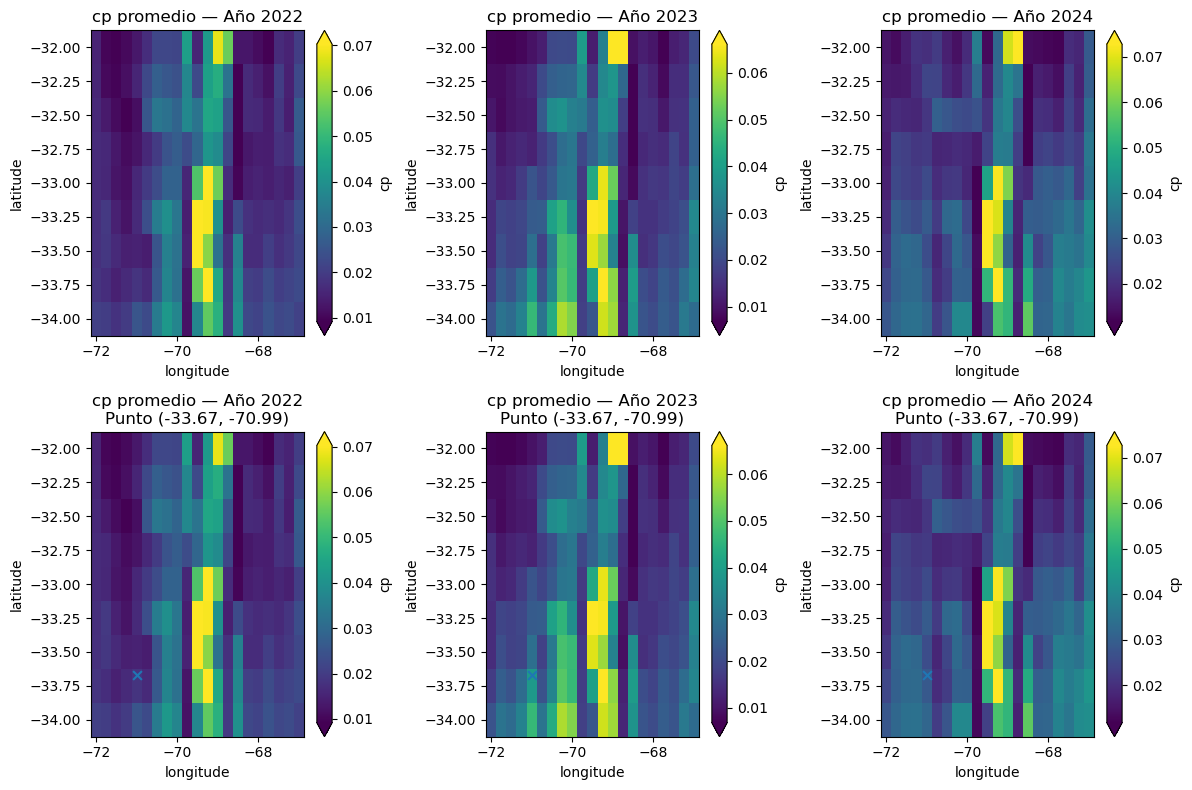

  - MÁXIMA HORARIA DIARIA (mm/h)


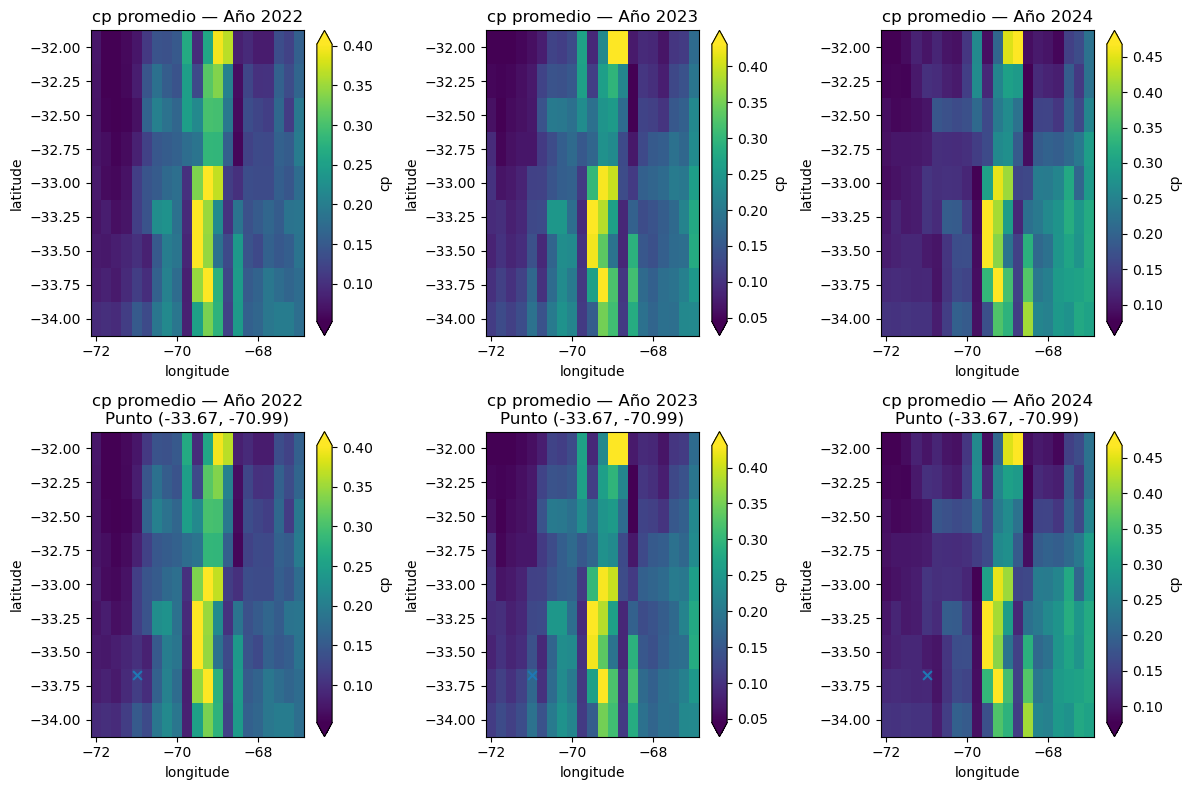

  - TOTAL DIARIA (mm/día)


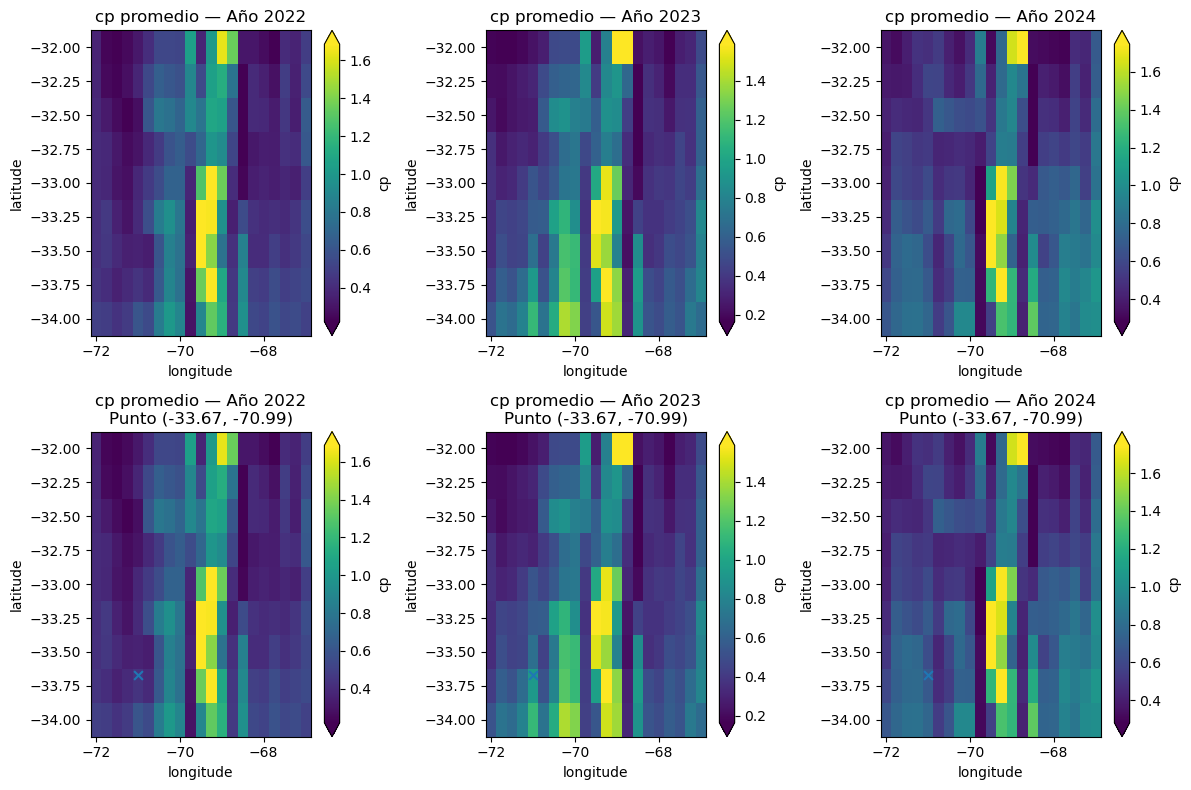

  - MEDIA DIARIA (mm/h)


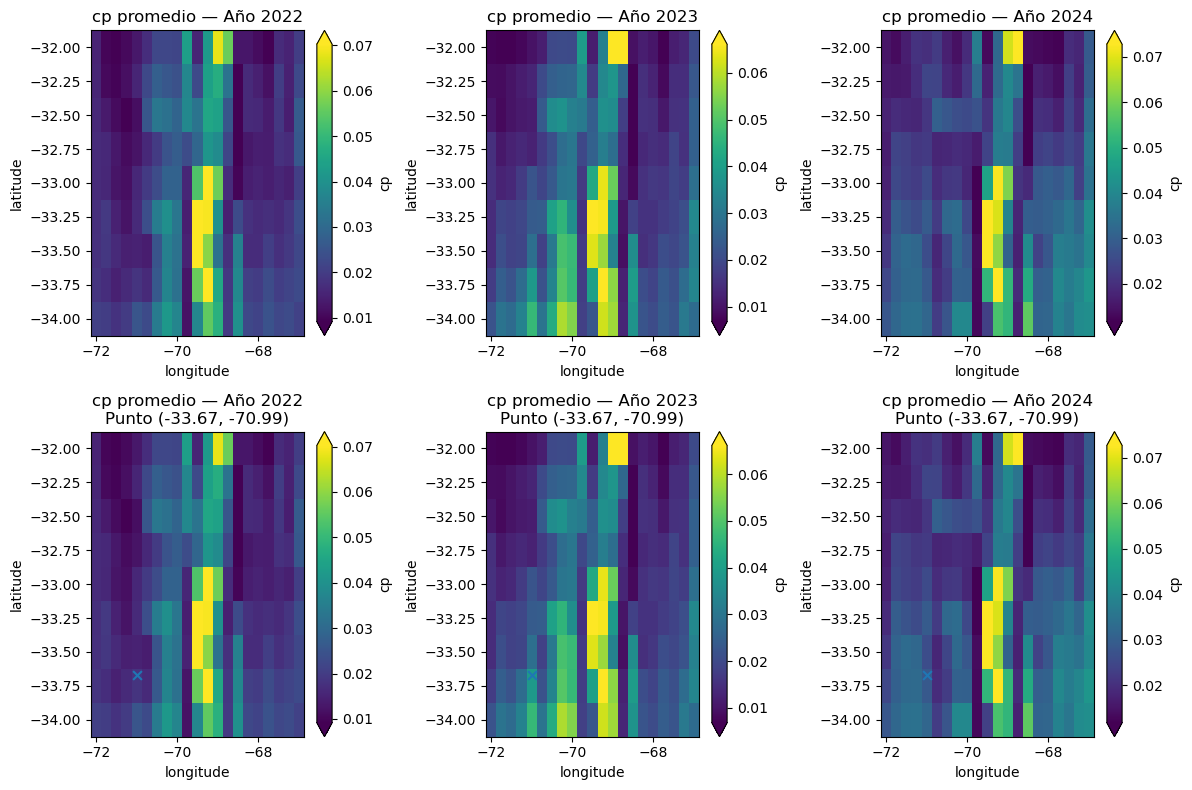


→ Variable 'lsp':
  - HORARIA (mm/h)


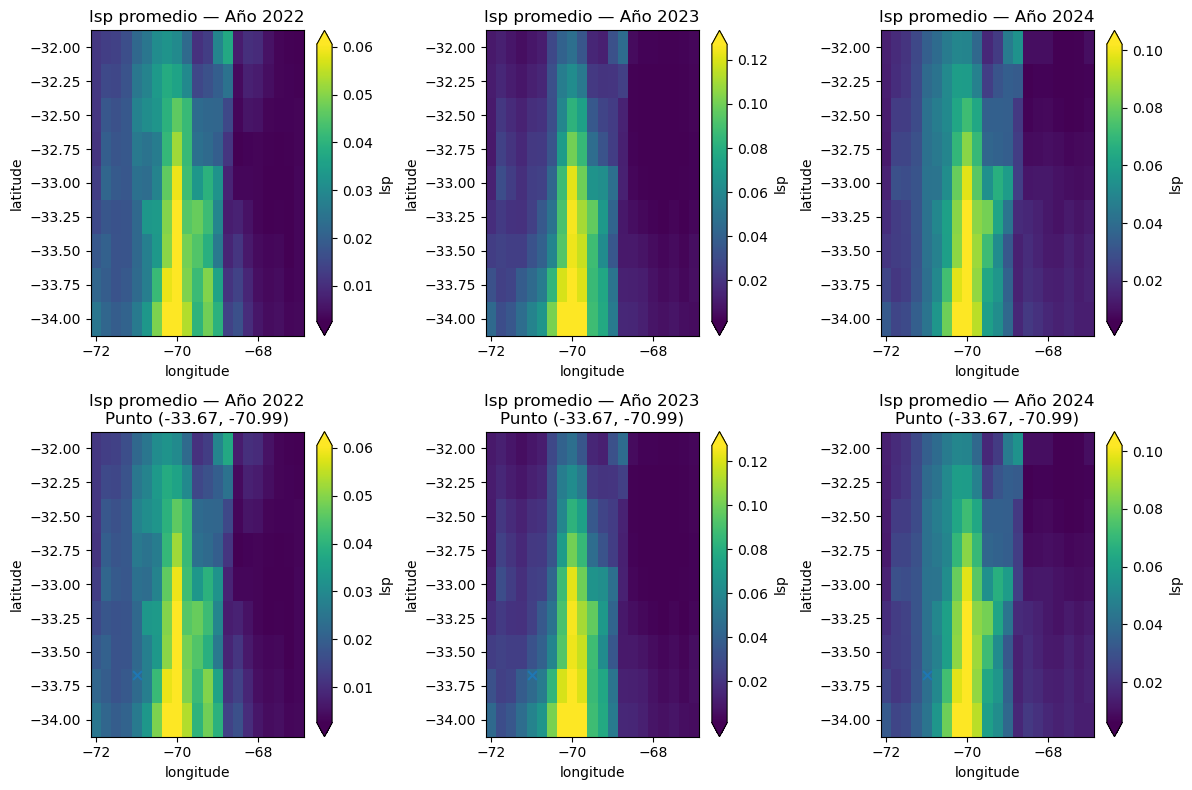

  - MÁXIMA HORARIA DIARIA (mm/h)


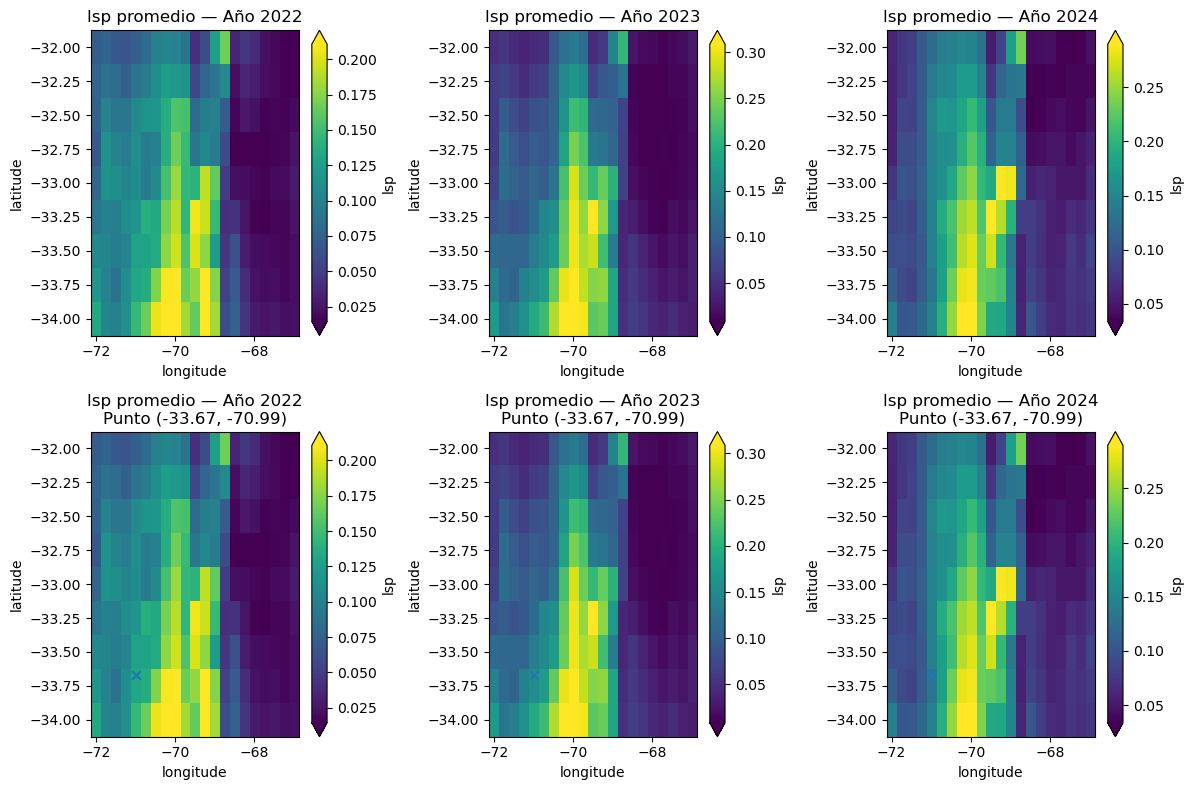

  - TOTAL DIARIA (mm/día)


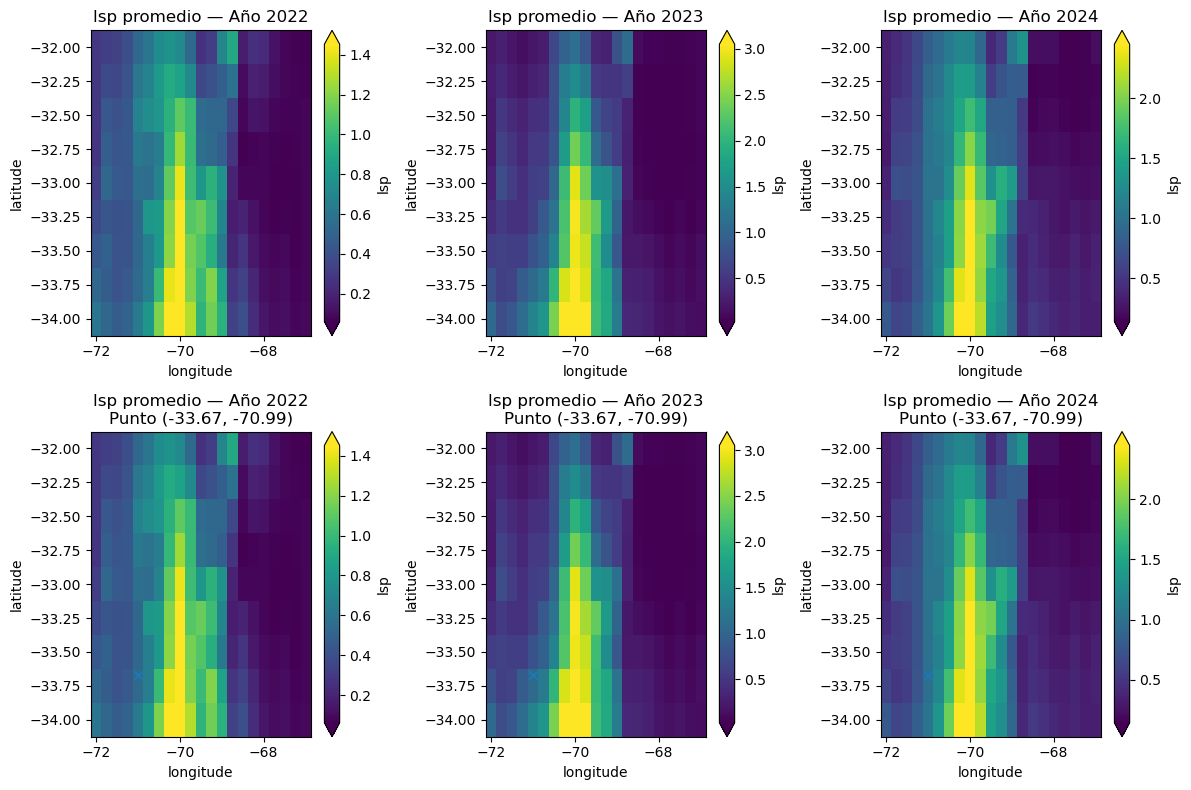

  - MEDIA DIARIA (mm/h)


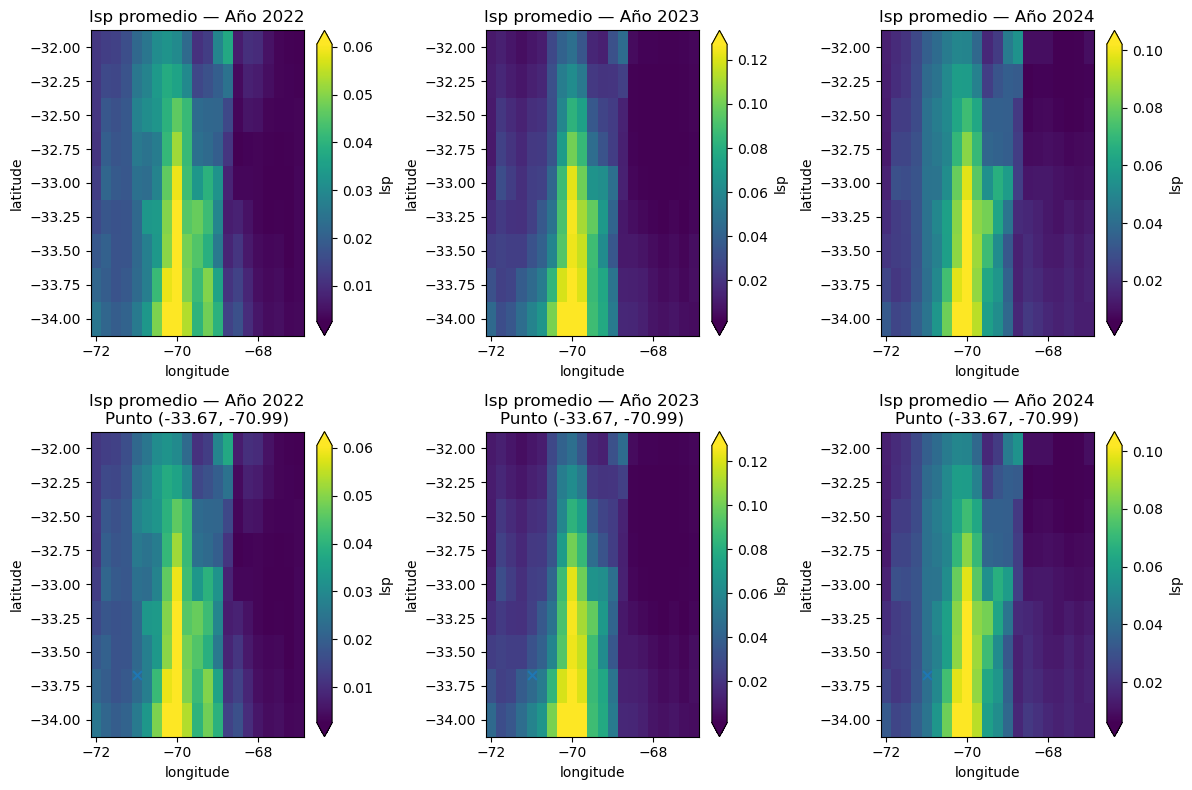

In [132]:
print("\n=== Mapas agrupados por variable ===")
for v in var:
    print(f"\n→ Variable '{v}':")
    
    print(f"  - HORARIA (mm/h)")
    da = ds_pp_hora[v].rename(v)
    _assert_dims(da)
    plot_mapas_promedio_por_anio(da, v, ds_pp_hora, punto_monte_interes)
    
    print(f"  - MÁXIMA HORARIA DIARIA (mm/h)")
    da = ds_pp_diamax[v].rename(v)
    _assert_dims(da)
    plot_mapas_promedio_por_anio(da, v, ds_pp_diamax, punto_monte_interes)
    
    print(f"  - TOTAL DIARIA (mm/día)")
    da = ds_pp_dia[v].rename(v)
    _assert_dims(da)
    plot_mapas_promedio_por_anio(da, v, ds_pp_dia, punto_monte_interes)
    
    print(f"  - MEDIA DIARIA (mm/h)")
    da = ds_pp_diamed[v].rename(v)
    _assert_dims(da)
    plot_mapas_promedio_por_anio(da, v, ds_pp_diamed, punto_monte_interes)



=== SERIES TEMPORALES: PRECIP HORARIA (mm/h) ===


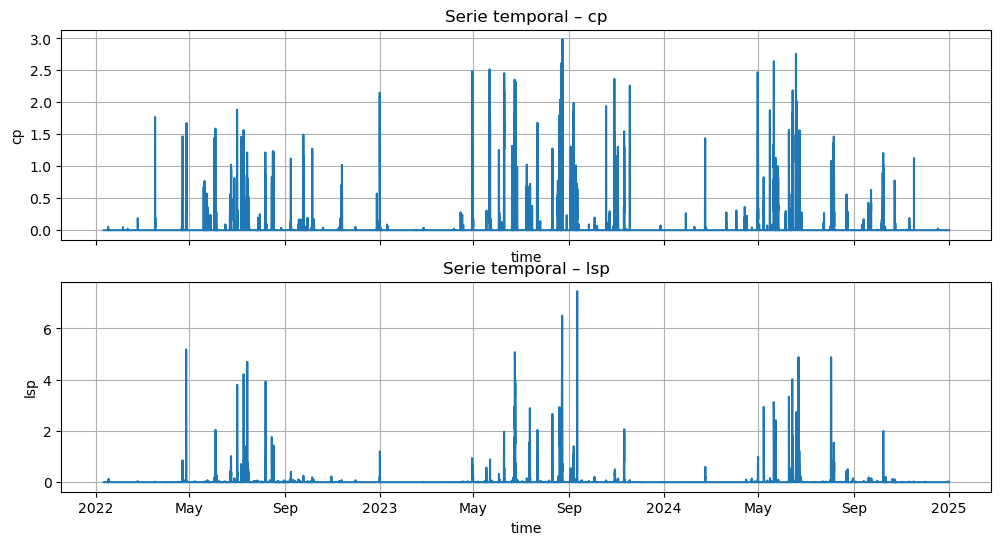


=== SERIES TEMPORALES: PRECIP MÁXIMA HORARIA DIARIA (mm/h) ===


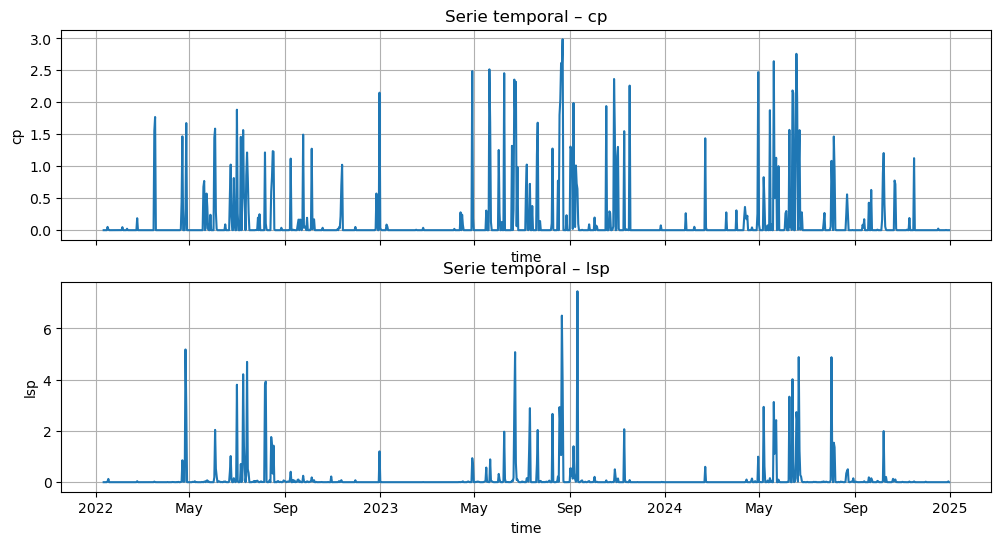


=== SERIES TEMPORALES: PRECIP TOTAL DIARIA (mm/día) ===


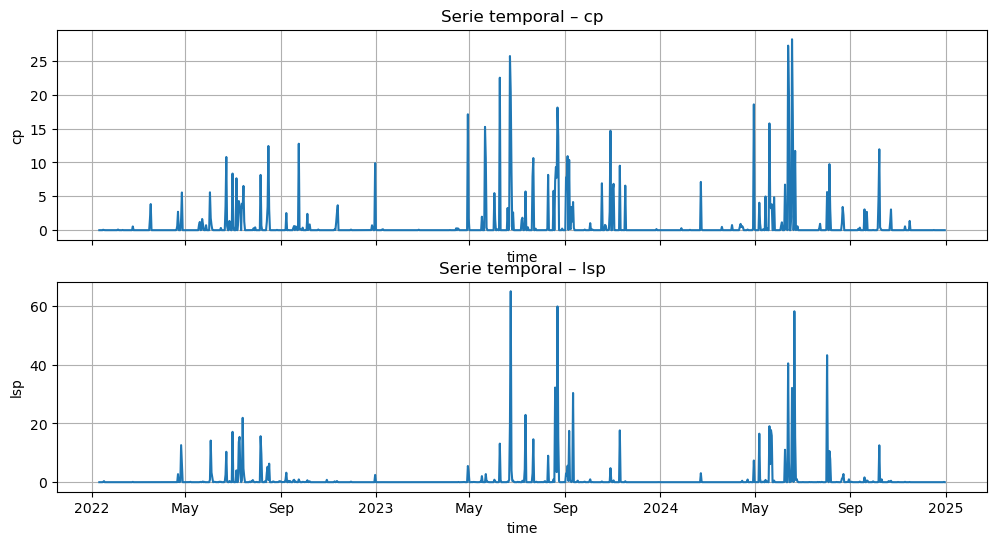


=== SERIES TEMPORALES: PRECIP MEDIA DIARIA (mm/h) ===


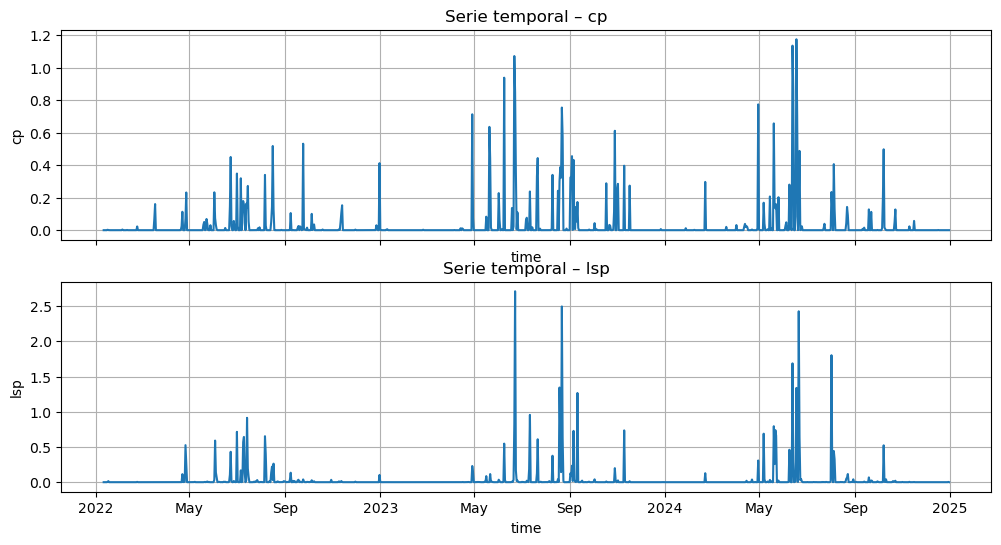

In [152]:
def plot_series_temporales_column(ds, vars_lista, punto_interes, t_inicio=None, t_final=None):
    """
    Hace un vector columna de series de tiempo:
    una fila por variable en vars_lista.
    
    t_inicio, t_final: strings con formato 'YYYY-MM-DD' para filtrar periodo
    """
    lat_p, lon_p = punto_interes

    # Filtrar periodo temporal si se especifica
    if t_inicio is not None or t_final is not None:
        time_name = "time" if "time" in ds.coords else "valid_time"
        ds = ds.sel({time_name: slice(t_inicio, t_final)})

    nvar = len(vars_lista)
    fig, axes = plt.subplots(
        nvar, 1,
        figsize=(12, 3 * nvar),
        sharex=True,
        squeeze=False
    )

    # Detectar nombres de coordenadas espaciales
    lat_name = "latitude" if "latitude" in ds.coords else "lat"
    lon_name = "longitude" if "longitude" in ds.coords else "lon"

    for i, v in enumerate(vars_lista):
        ax = axes[i, 0]

        # DataArray de la variable
        da = ds[v]

        # Serie en el punto de interés (cambia a .mean si quieres promedio espacial)
        da_point = da.sel(
            {lat_name: lat_p, lon_name: lon_p},
            method="nearest"
        )

        da_point.plot(ax=ax)
        ax.set_title(f"Serie temporal – {v}")
        ax.set_ylabel(v)
        ax.grid(True)
    
    plt.show()

# ============================
# SERIES TEMPORALES — CUATRO FRECUENCIAS
# ============================

# ============================
# SERIES TEMPORALES — CUATRO FRECUENCIAS
# ============================



print("\n=== SERIES TEMPORALES: PRECIP HORARIA (mm/h) ===")
plot_series_temporales_column(
    ds_pp_hora,
    var,
    punto_monte_interes,
    t_inicio="2022-01-11",
    t_final="2024-12-31"
)
print("\n=== SERIES TEMPORALES: PRECIP MÁXIMA HORARIA DIARIA (mm/h) ===")
plot_series_temporales_column(
    ds_pp_diamax,
    var,
    punto_monte_interes,
    t_inicio="2022-01-11",
    t_final="2024-12-31"
)

print("\n=== SERIES TEMPORALES: PRECIP TOTAL DIARIA (mm/día) ===")
plot_series_temporales_column(
    ds_pp_dia,
    var,
    punto_monte_interes,
    t_inicio="2022-01-11",
    t_final="2024-12-31"
)

print("\n=== SERIES TEMPORALES: PRECIP MEDIA DIARIA (mm/h) ===")
plot_series_temporales_column(
    ds_pp_diamed,
    var,
    punto_monte_interes,
    t_inicio="2022-01-11",
    t_final="2024-12-31"
)




=== Histogramas agrupados por variable ===

→ Variable 'cp':
  - HORARIA (mm/h)


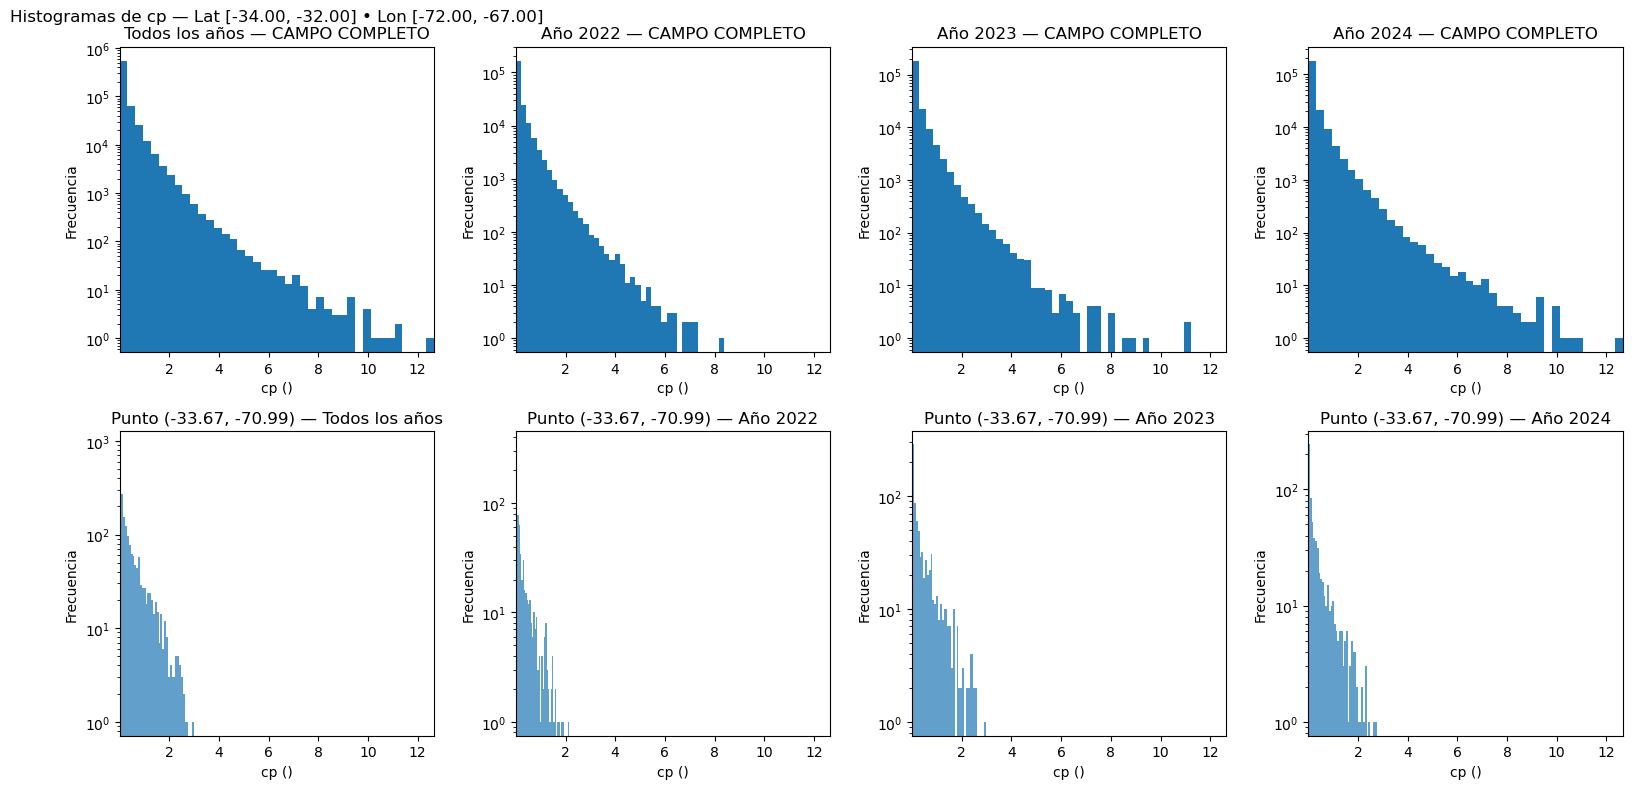

  - MÁXIMA HORARIA DIARIA (mm/h)


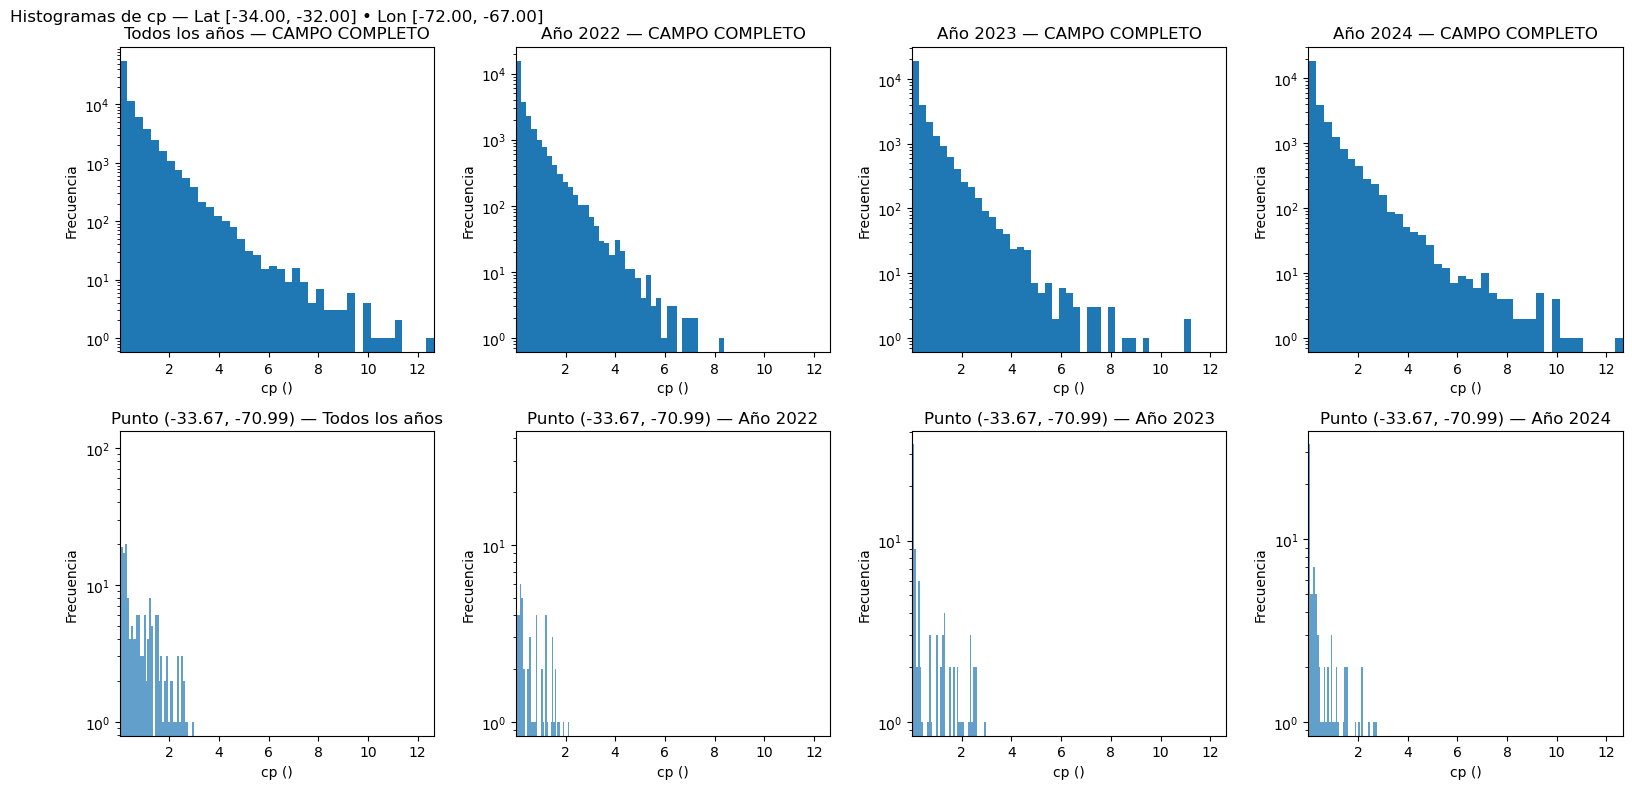

  - TOTAL DIARIA (mm/día)


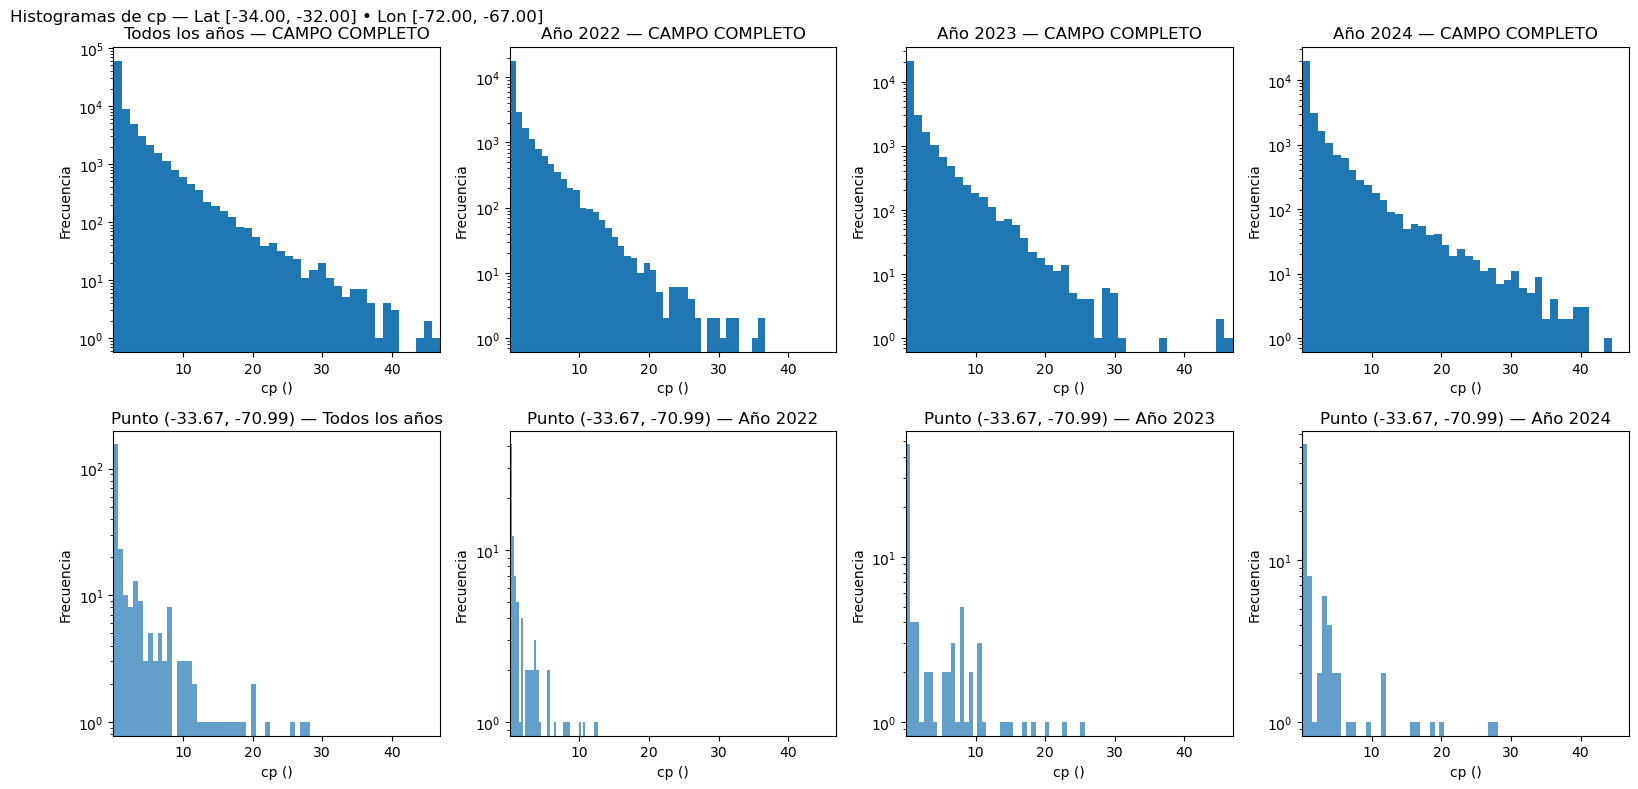

  - MEDIA DIARIA (mm/h)


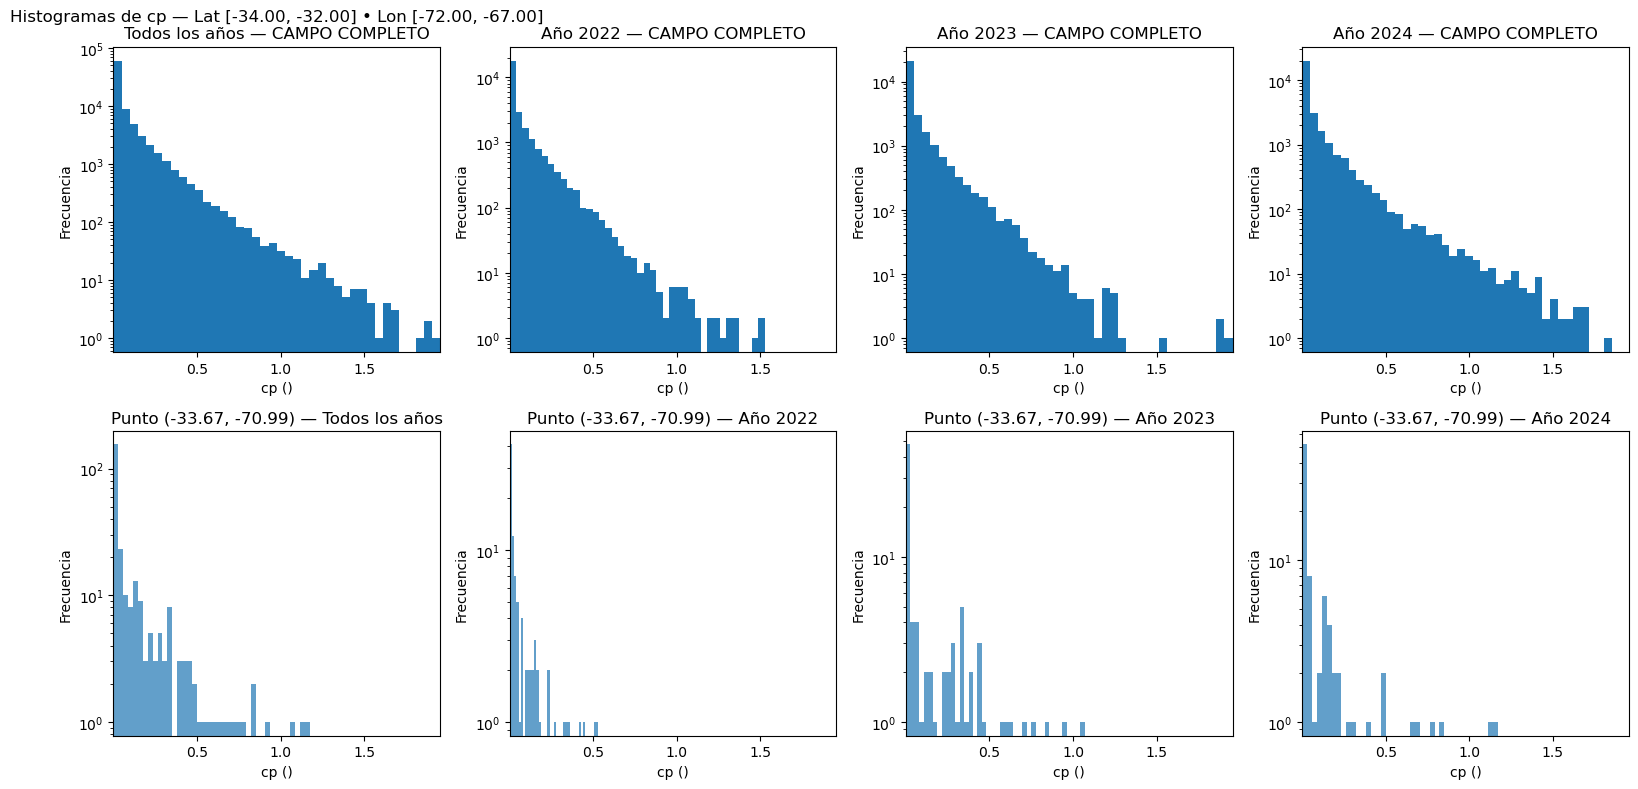


→ Variable 'lsp':
  - HORARIA (mm/h)


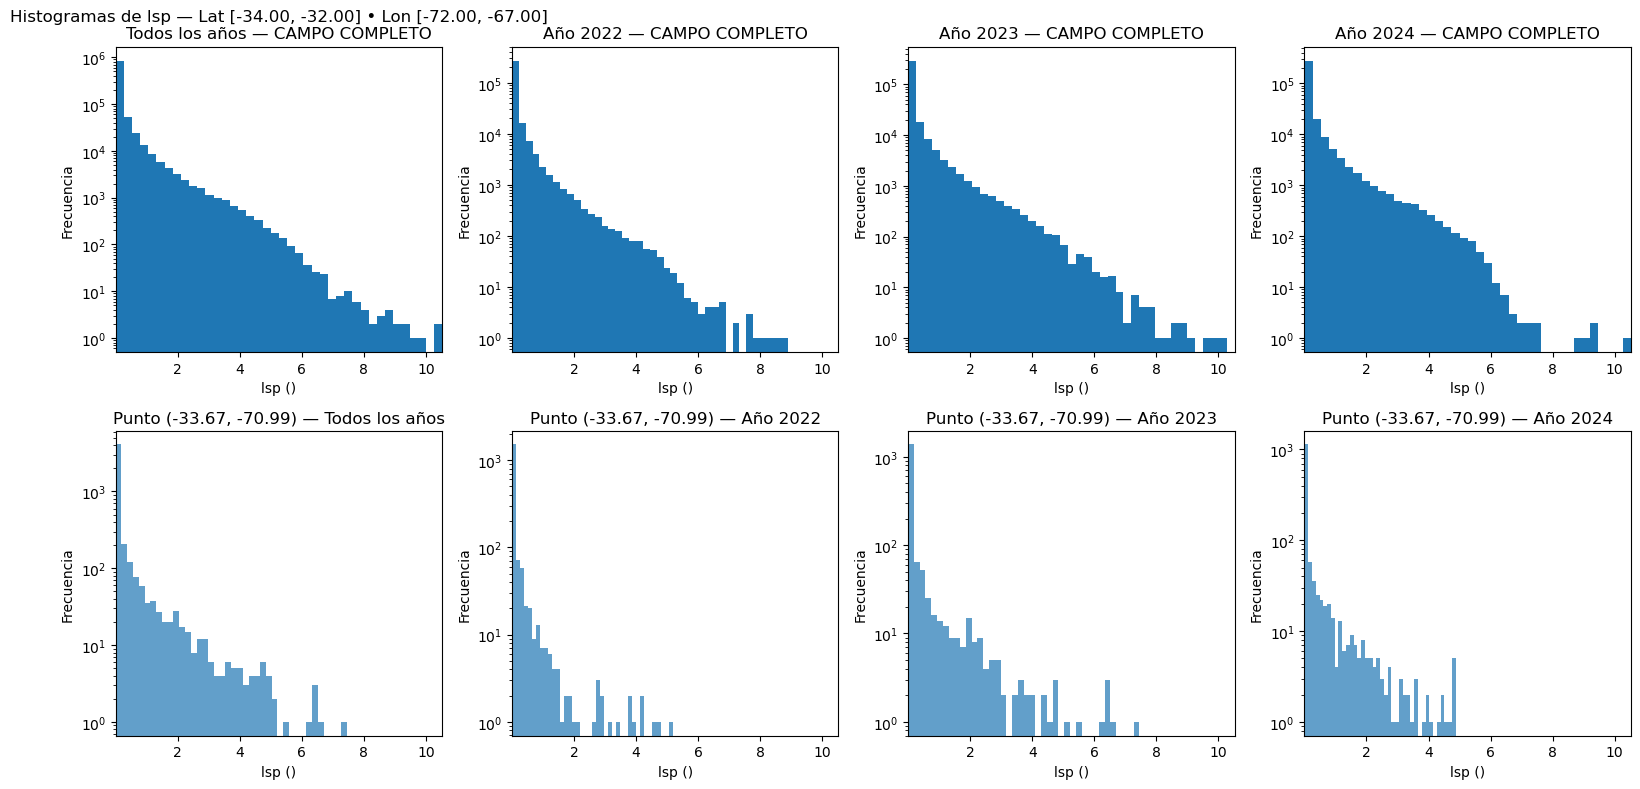

  - MÁXIMA HORARIA DIARIA (mm/h)


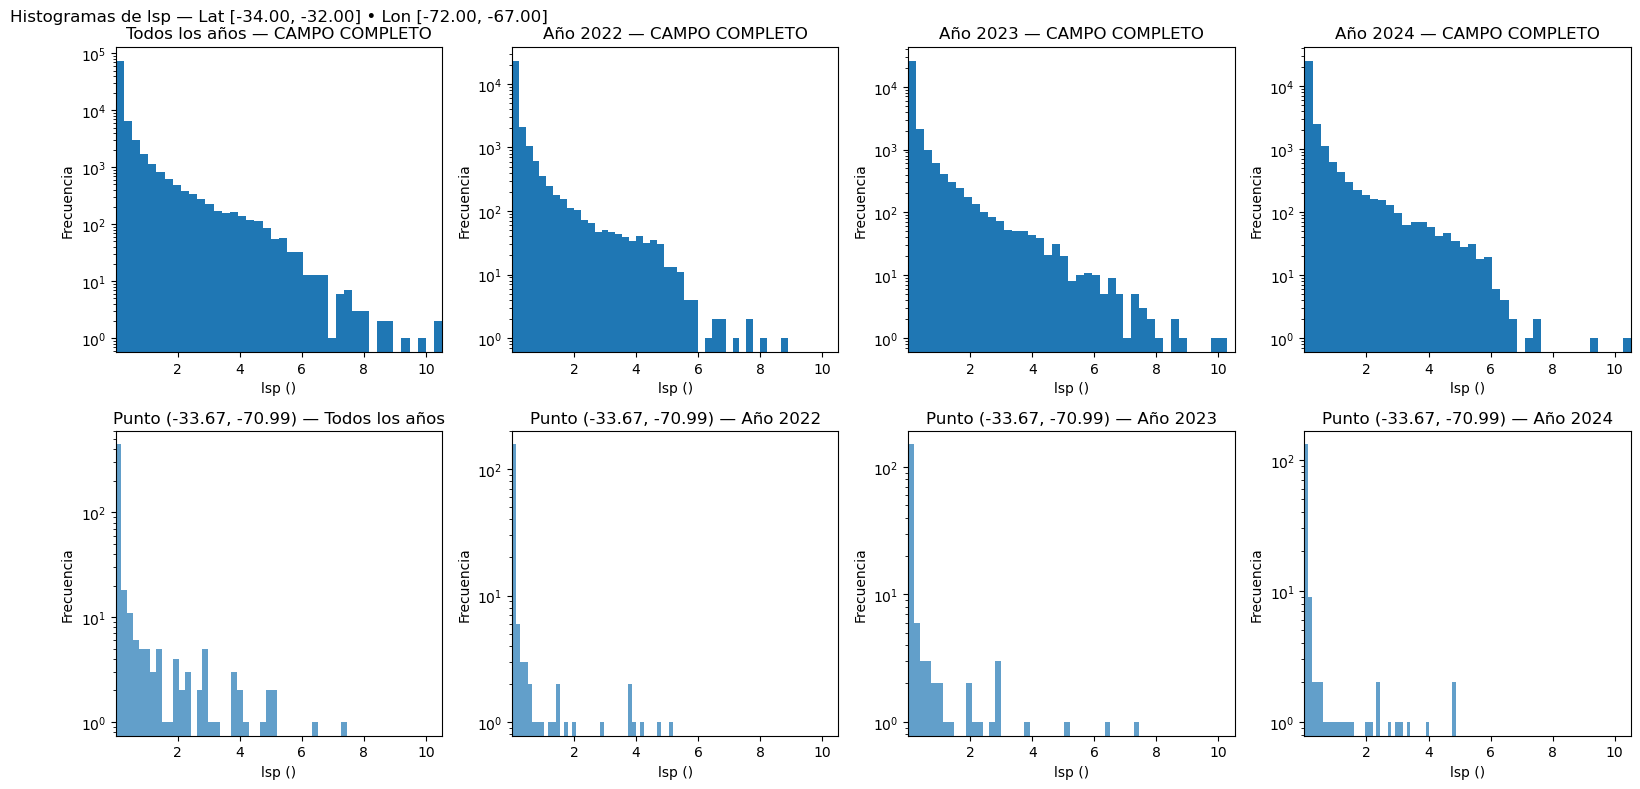

  - TOTAL DIARIA (mm/día)


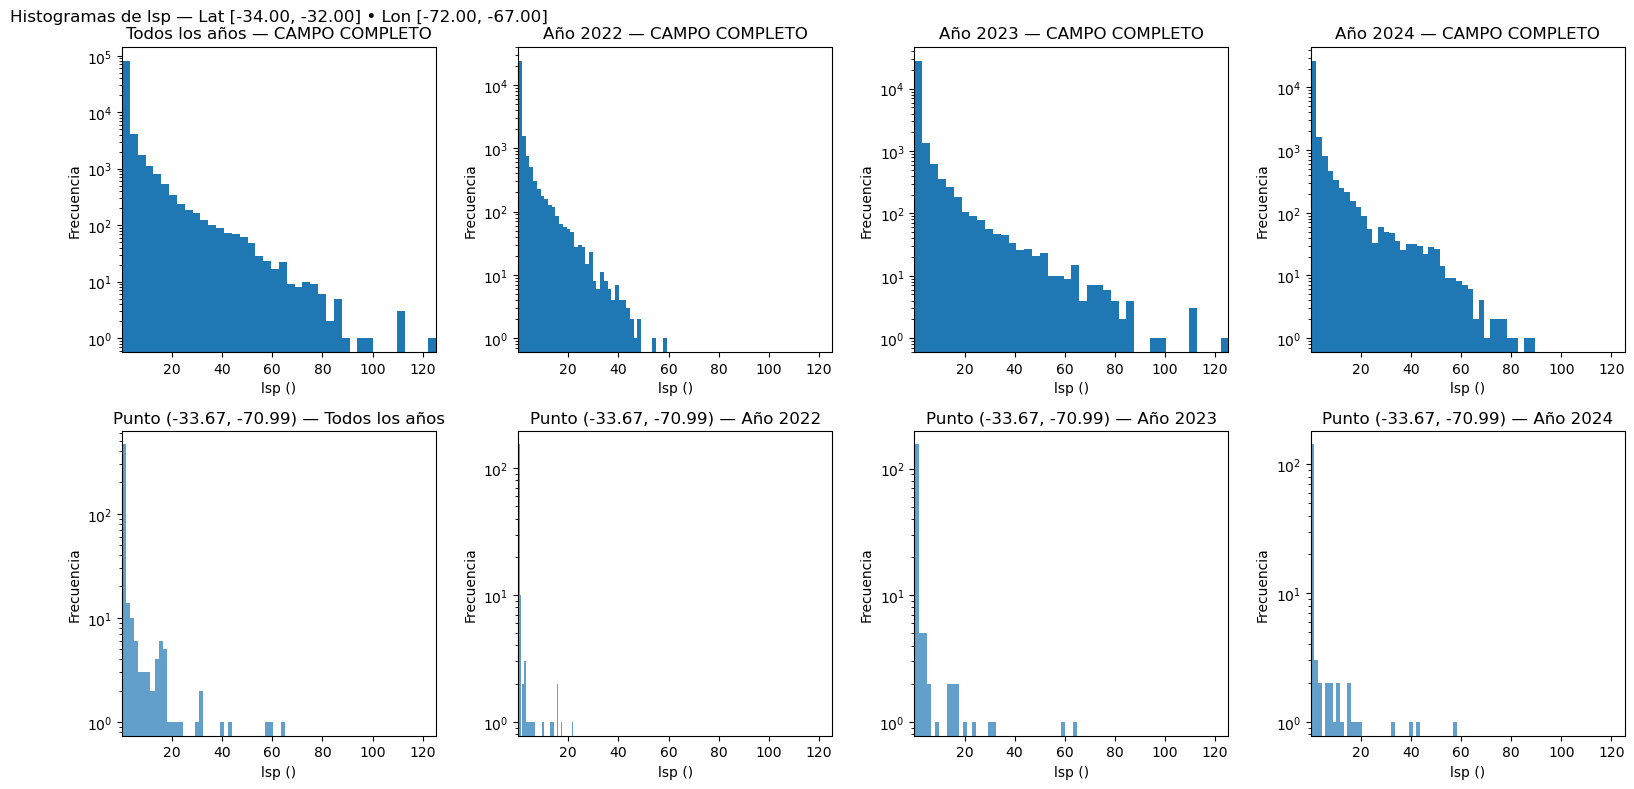

  - MEDIA DIARIA (mm/h)


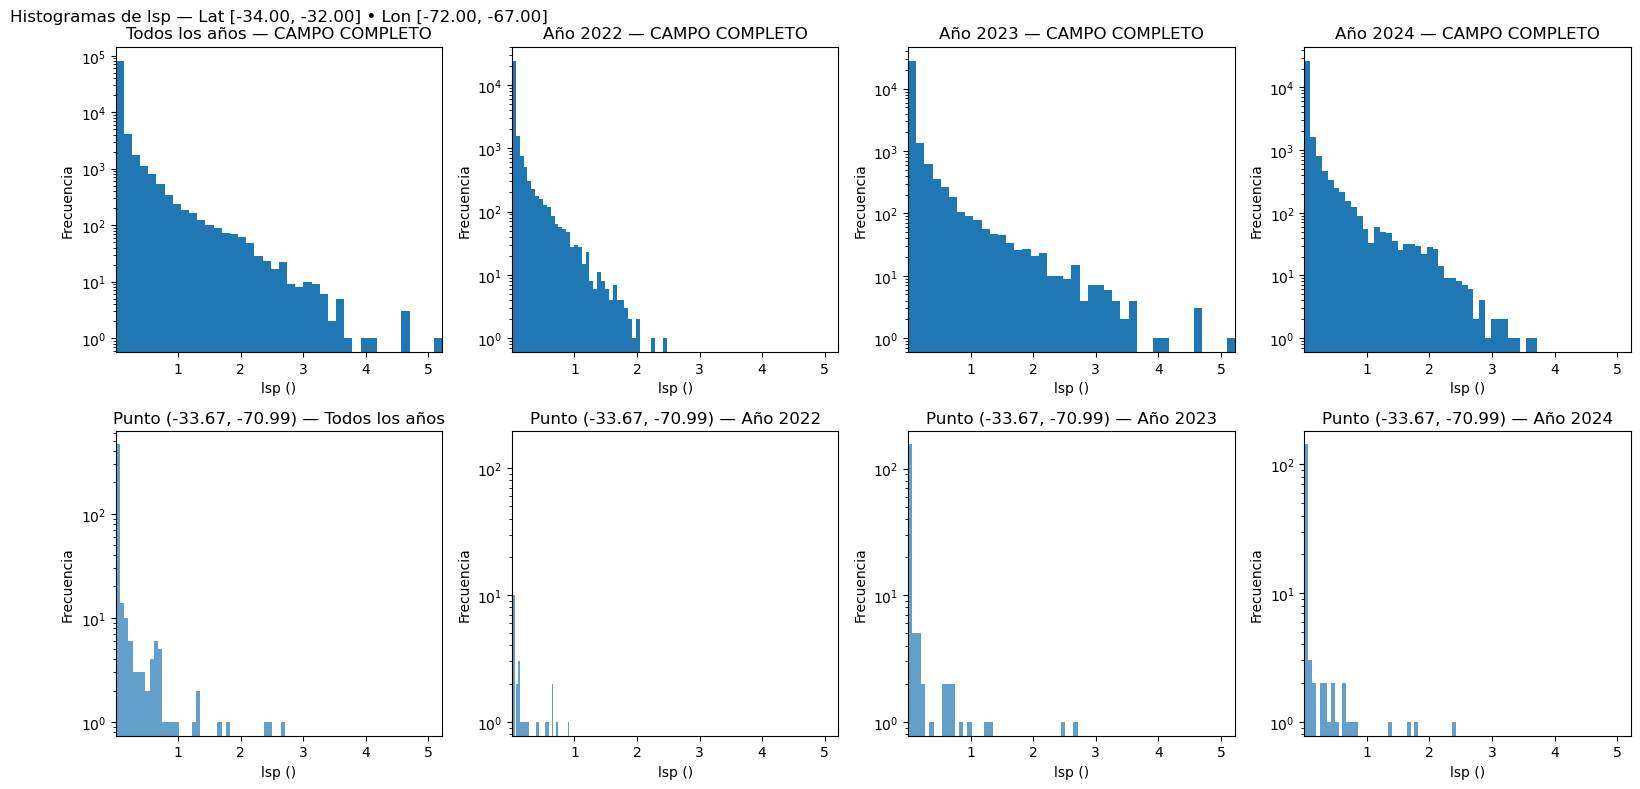

In [154]:

print("\n=== Histogramas agrupados por variable ===")
for v in var:
    print(f"\n→ Variable '{v}':")
    
    # ---------- HORARIA ----------
    print("  - HORARIA (mm/h)")
    da = ds_pp_hora[v].rename(v)
    _assert_dims(da)
    plot_histogramas_lluvia_por_anio(
        da,
        v,
        ds_pp_hora,
        punto_monte_interes,
        nbins=40,
        log_y=True,        # eje Y logarítmico
        solo_positivos=True
    )

    # ---------- MÁXIMA HORARIA DIARIA ----------
    print("  - MÁXIMA HORARIA DIARIA (mm/h)")
    da = ds_pp_diamax[v].rename(v)
    _assert_dims(da)
    plot_histogramas_lluvia_por_anio(
        da,
        v,
        ds_pp_diamax,
        punto_monte_interes,
        nbins=40,
        log_y=True,
        solo_positivos=True
    )

    # ---------- TOTAL DIARIA ----------
    print("  - TOTAL DIARIA (mm/día)")
    da = ds_pp_dia[v].rename(v)
    _assert_dims(da)
    plot_histogramas_lluvia_por_anio(
        da,
        v,
        ds_pp_dia,
        punto_monte_interes,
        nbins=40,
        log_y=True,
        solo_positivos=True
    )

    # ---------- MEDIA DIARIA ----------
    print("  - MEDIA DIARIA (mm/h)")
    da = ds_pp_diamed[v].rename(v)
    _assert_dims(da)
    plot_histogramas_lluvia_por_anio(
        da,
        v,
        ds_pp_diamed,
        punto_monte_interes,
        nbins=40,
        log_y=True,
        solo_positivos=True
    )
